# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [22]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


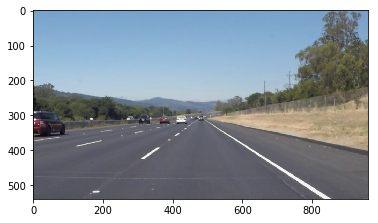

In [23]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [24]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    l_x, l_y, r_x, r_y = img.shape[1],0,0,0 
    l_x_mid, l_y_mid, r_x_mid, r_y_mid = 0,img.shape[0],img.shape[1],img.shape[0]
    l_grad, r_grad = -0.7,0.7
    
    for line in lines:
        # calc gradient
        for x1,y1,x2,y2 in line:
            gradient = np.round(((y2-y1)/(x2-x1)), decimals = 2)
            length = np.round(np.sqrt(np.square(y2-y1) + np.square(x2-x1)), decimals = 2)
            
            if np.absolute(gradient) > 0.55 and np.absolute(gradient) < 0.8:
                if gradient > 0: # right line
                    if x2 > r_x:
                        r_x = x2
                    if y2 > r_y:
                        r_y = y2
                    r_grad = gradient
                    
                    if x1 < r_x_mid:
                        r_x_mid = x1
                    if y1 < r_y_mid:
                        r_y_mid = y1
                        
                elif gradient < 0: # left line
                    # find bottum left corner
                    if x1 < l_x:
                        l_x = x1
                    if y1 > l_y:
                        l_y = y1
                    l_grad = gradient
                    
                    # find top right bit
                    if x2 > l_x_mid:
                        l_x_mid = x2
                    if y2 < l_y_mid:
                        l_y_mid = y2
                    
            
            if not np.isnan(length) and np.absolute(gradient)>0.3 \
            and np.absolute(gradient)<0.9:
                print("{0} l: {1} points: {2}".format(gradient, length, line)) 
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
    # extra fill line
    if r_y < 0.95*img.shape[0]:
        x_extrap = (img.shape[0]-r_y)/r_grad + r_x
        cv2.line(img, (r_x_mid, r_y_mid), (int(x_extrap), int(img.shape[0])), color, thickness)
    
    # extra fill line
    if l_y < 0.95*img.shape[0]:
        l_x_extrap = (img.shape[0]-l_y)/l_grad + l_x # check
        cv2.line(img, ( int(l_x_extrap), int(img.shape[0]) ), (l_x_mid, l_y_mid), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [25]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [26]:
#plots out the image
def plot_image(filename: str) -> None:
    image = mpimg.imread(filename)
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [27]:
test_list = os.listdir("test_images/")

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


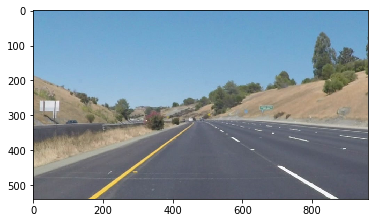

In [28]:
for image in test_list:
    plot_image(os.path.join('test_images', image))

In [29]:
# parameters
blur_kernel = 5
canny_low_threshold = 50
canny_high_threshold = 150

# hough
rho = 2 
theta = np.pi/180
threshold = 16
min_line_len = 5
max_line_gap = 50

In [30]:
def pipeline(image, blur_kernel=5, canny_low_threshold=25, canny_high_threshold=150, 
             rho=2, theta=np.pi/180, threshold=16, min_line_len=5, max_line_gap=50):
    
    grey_image = grayscale(image)
    # blur
    blur_image = gaussian_blur(grey_image, blur_kernel)
    # canny
    canny_image = canny(blur_image, canny_low_threshold, canny_high_threshold)
    # region of interest
    image_shape = canny_image.shape
    vertices = np.array([[(0.1*image_shape[1],image_shape[0]),
                          (image_shape[1]*0.95, image_shape[0]), 
                          (0.55*image_shape[1], 0.6*image_shape[0]), 
                          (0.45*image_shape[1],0.6*image_shape[0])]], dtype=np.int32)
    masked_region = region_of_interest(canny_image, vertices)
    # hough
    hough_output = hough_lines(masked_region, rho, theta, threshold, min_line_len, max_line_gap)
    # output
    full_output = weighted_img(hough_output, image)
    return full_output

-0.75 l: 352.0 points: [[178 538 459 326]]
0.57 l: 186.8 points: [[712 445 874 538]]
-0.73 l: 171.82 points: [[317 425 456 324]]
0.62 l: 167.06 points: [[700 446 842 534]]
-0.74 l: 92.2 points: [[231 487 305 432]]
0.65 l: 138.13 points: [[511 325 627 400]]
-0.7 l: 24.41 points: [[326 425 346 411]]
0.65 l: 94.03 points: [[505 324 584 375]]
-0.77 l: 54.2 points: [[194 514 237 481]]
-0.74 l: 67.2 points: [[343 406 397 366]]
0.63 l: 41.34 points: [[816 516 851 538]]
0.55 l: 150.84 points: [[502 324 634 397]]
-0.76 l: 46.4 points: [[296 440 333 412]]
-0.73 l: 40.8 points: [[338 416 371 392]]
-0.78 l: 40.61 points: [[175 528 207 503]]
-0.76 l: 21.4 points: [[160 538 177 525]]
0.64 l: 33.29 points: [[794 503 822 521]]
-0.77 l: 65.6 points: [[358 402 410 362]]
-0.73 l: 18.6 points: [[180 538 195 527]]
-0.78 l: 22.8 points: [[236 483 254 469]]
-0.37 l: 20.25 points: [[421 331 440 324]]
-0.4 l: 10.77 points: [[215 465 225 461]]
0.65 l: 139.52 points: [[509 324 626 400]]
-0.48 l: 29.97 points: [[

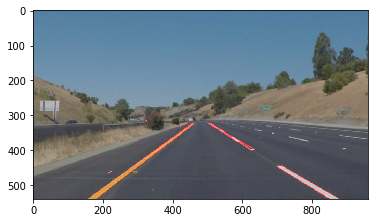

In [31]:
used_image = mpimg.imread(os.path.join('test_images', test_list[5]))
final_output = pipeline(used_image)
plt.imshow(final_output)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = pipeline(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [35]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 7/221 [00:00<00:03, 67.59it/s, now=None]

0.6 l: 415.37 points: [[513 324 869 538]]
0.63 l: 177.02 points: [[698 444 848 538]]
-0.75 l: 135.0 points: [[202 514 310 433]]
-0.75 l: 140.0 points: [[187 515 299 431]]
0.61 l: 107.7 points: [[549 350 641 406]]
0.6 l: 232.38 points: [[515 324 714 444]]
0.61 l: 66.89 points: [[634 403 691 438]]
0.61 l: 139.09 points: [[507 324 626 396]]
-0.74 l: 77.2 points: [[187 513 249 467]]
-0.72 l: 114.62 points: [[362 391 455 324]]
-0.75 l: 90.0 points: [[359 391 431 337]]
-0.78 l: 116.82 points: [[308 430 400 358]]
-0.75 l: 111.4 points: [[361 391 450 324]]
0.62 l: 141.51 points: [[727 463 847 538]]
-0.76 l: 42.8 points: [[210 497 244 471]]
-0.72 l: 111.02 points: [[360 391 450 326]]
0.59 l: 19.72 points: [[700 445 717 455]]
0.67 l: 14.42 points: [[517 329 529 337]]
0.61 l: 32.76 points: [[672 427 700 444]]
-0.78 l: 109.02 points: [[189 515 275 448]]
-0.79 l: 17.8 points: [[283 444 297 433]]
0.58 l: 73.93 points: [[804 500 868 537]]
-0.84 l: 127.78 points: [[262 470 360 388]]
Moviepy - Building

t:  10%|▉         | 22/221 [00:00<00:02, 69.84it/s, now=None]

0.67 l: 21.63 points: [[651 414 669 426]]
-0.74 l: 53.6 points: [[230 483 273 451]]
0.53 l: 19.24 points: [[818 529 835 538]]
0.65 l: 44.1 points: [[566 361 603 385]]
0.61 l: 38.59 points: [[756 489 789 509]]
-0.72 l: 85.21 points: [[298 435 367 385]]
0.63 l: 71.02 points: [[502 324 562 362]]
-0.75 l: 100.0 points: [[322 421 402 361]]
-0.78 l: 104.02 points: [[373 388 455 324]]
0.64 l: 29.68 points: [[737 466 762 482]]
0.64 l: 76.01 points: [[515 329 579 370]]
0.56 l: 83.73 points: [[576 372 649 413]]
0.58 l: 21.95 points: [[787 509 806 520]]
0.68 l: 23.02 points: [[603 384 622 397]]
-0.75 l: 30.0 points: [[248 470 272 452]]
-0.73 l: 105.21 points: [[239 485 324 423]]
0.38 l: 51.26 points: [[750 485 798 503]]
-0.6 l: 61.91 points: [[393 368 446 336]]
0.65 l: 394.7 points: [[502 324 833 539]]
0.62 l: 307.72 points: [[511 326 772 489]]
0.62 l: 92.96 points: [[776 490 855 539]]
-0.7 l: 144.27 points: [[183 515 301 432]]
-0.67 l: 123.98 points: [[357 393 460 324]]
-0.75 l: 115.0 points: [[

t:  18%|█▊        | 39/221 [00:00<00:02, 73.62it/s, now=None]

0.63 l: 390.4 points: [[523 331 854 538]]
0.65 l: 336.72 points: [[508 325 790 509]]
-0.7 l: 127.88 points: [[142 539 247 466]]
-0.73 l: 138.81 points: [[345 406 457 324]]
-0.76 l: 122.8 points: [[164 539 262 465]]
0.65 l: 186.39 points: [[676 435 832 537]]
0.63 l: 403.44 points: [[513 324 855 538]]
-0.67 l: 87.92 points: [[377 376 450 327]]
-0.76 l: 52.8 points: [[196 516 238 484]]
-0.53 l: 36.24 points: [[226 481 258 464]]
-0.68 l: 141.17 points: [[337 404 454 325]]
0.62 l: 28.3 points: [[507 324 531 339]]
-0.78 l: 11.4 points: [[252 475 261 468]]
-0.63 l: 67.42 points: [[195 501 252 465]]
0.64 l: 26.08 points: [[794 513 816 527]]
-0.86 l: 46.1 points: [[413 355 448 325]]
-0.71 l: 51.61 points: [[204 497 246 467]]
0.58 l: 13.89 points: [[821 531 833 538]]
-0.8 l: 32.02 points: [[236 487 261 467]]
-0.71 l: 124.85 points: [[341 406 443 334]]
-0.73 l: 139.62 points: [[338 406 451 324]]
0.65 l: 359.19 points: [[532 341 833 537]]
0.63 l: 378.74 points: [[534 338 855 539]]
-0.72 l: 75.21 p

t:  24%|██▍       | 53/221 [00:00<00:02, 62.08it/s, now=None]

0.63 l: 250.27 points: [[642 406 854 539]]
0.67 l: 250.73 points: [[511 324 719 464]]
0.69 l: 61.85 points: [[564 354 615 389]]
0.69 l: 65.46 points: [[765 493 819 530]]
-0.67 l: 120.37 points: [[354 391 454 324]]
-0.86 l: 76.58 points: [[363 392 421 342]]
0.7 l: 45.22 points: [[723 465 760 491]]
0.67 l: 95.13 points: [[519 325 598 378]]
0.68 l: 23.02 points: [[622 392 641 405]]
0.75 l: 10.0 points: [[657 414 665 420]]
0.71 l: 17.2 points: [[665 419 679 429]]
0.64 l: 94.87 points: [[719 453 799 504]]
-0.72 l: 113.23 points: [[355 390 447 324]]
0.73 l: 32.2 points: [[806 520 832 539]]
0.71 l: 17.2 points: [[724 466 738 476]]
0.75 l: 20.0 points: [[753 485 769 497]]
0.62 l: 24.7 points: [[834 525 855 538]]
-0.78 l: 110.42 points: [[360 393 447 325]]
-0.68 l: 83.49 points: [[354 393 423 346]]
0.65 l: 47.71 points: [[673 424 713 450]]
0.7 l: 24.41 points: [[600 378 620 392]]
0.65 l: 47.71 points: [[772 486 812 512]]
0.73 l: 27.2 points: [[762 491 784 507]]
-0.64 l: 33.29 points: [[357 393 

t:  27%|██▋       | 59/221 [00:00<00:02, 60.85it/s, now=None]

0.63 l: 306.87 points: [[592 374 852 537]]
0.67 l: 335.04 points: [[533 339 811 526]]
0.63 l: 246.66 points: [[513 324 722 455]]
-0.67 l: 39.66 points: [[136 537 169 515]]
-0.7 l: 162.29 points: [[304 423 437 330]]
-0.72 l: 169.03 points: [[312 423 449 324]]
-0.72 l: 35.81 points: [[156 538 185 517]]
0.68 l: 23.02 points: [[520 331 539 344]]
0.62 l: 43.57 points: [[614 394 651 417]]
-0.7 l: 173.1 points: [[305 423 447 324]]
0.5 l: 6.71 points: [[782 506 788 509]]
-0.74 l: 38.6 points: [[419 347 450 324]]
0.64 l: 16.64 points: [[507 324 521 333]]
-0.62 l: 43.57 points: [[135 538 172 515]]
0.64 l: 39.12 points: [[798 517 831 538]]
0.6 l: 48.88 points: [[811 513 853 538]]
-0.7 l: 107.65 points: [[365 386 453 324]]
0.6 l: 34.99 points: [[514 324 544 342]]
-0.75 l: 71.4 points: [[312 419 369 376]]
0.6 l: 11.66 points: [[672 432 682 438]]
0.65 l: 40.5 points: [[761 492 795 514]]
0.54 l: 64.88 points: [[514 328 571 359]]
0.57 l: 16.12 points: [[794 502 808 510]]
0.6 l: 11.66 points: [[712 459

t:  33%|███▎      | 74/221 [00:01<00:02, 63.09it/s, now=None]

-0.7 l: 112.07 points: [[363 388 455 324]]
0.66 l: 74.33 points: [[566 361 628 402]]
0.66 l: 59.91 points: [[541 345 591 378]]
-0.65 l: 112.06 points: [[356 386 450 325]]
0.68 l: 33.84 points: [[610 389 638 408]]
0.78 l: 62.01 points: [[511 325 560 363]]
-0.67 l: 180.83 points: [[301 425 451 324]]
-0.67 l: 170.02 points: [[302 426 443 331]]
0.71 l: 29.41 points: [[527 340 551 357]]
0.39 l: 19.31 points: [[521 337 539 344]]
-0.69 l: 15.81 points: [[133 535 146 526]]
-0.79 l: 17.8 points: [[149 539 163 528]]
-0.67 l: 25.24 points: [[130 539 151 525]]
0.43 l: 40.31 points: [[618 402 655 418]]
-0.62 l: 55.23 points: [[402 359 449 330]]
0.65 l: 183.62 points: [[688 438 842 538]]
0.55 l: 47.89 points: [[512 331 554 354]]
0.5 l: 29.07 points: [[504 325 530 338]]
0.71 l: 8.6 points: [[641 409 648 414]]
0.67 l: 340.87 points: [[508 328 791 518]]
0.66 l: 45.49 points: [[646 412 684 437]]
-0.86 l: 9.22 points: [[152 536 159 530]]
-0.67 l: 7.21 points: [[414 348 420 344]]
-0.5 l: 17.89 points: [[1

t:  40%|███▉      | 88/221 [00:01<00:02, 65.08it/s, now=None]

0.68 l: 249.9 points: [[611 398 818 538]]
0.65 l: 380.28 points: [[520 331 839 538]]
0.72 l: 61.61 points: [[506 324 556 360]]
-0.65 l: 122.87 points: [[344 392 447 325]]
0.65 l: 395.54 points: [[507 324 839 539]]
-0.67 l: 118.98 points: [[345 390 444 324]]
0.66 l: 63.51 points: [[563 365 616 400]]
0.68 l: 151.16 points: [[692 454 817 539]]
-0.72 l: 116.02 points: [[351 392 445 324]]
-0.65 l: 120.65 points: [[347 392 448 326]]
-0.67 l: 107.34 points: [[353 391 442 331]]
0.74 l: 23.6 points: [[546 352 565 366]]
0.65 l: 31.06 points: [[632 412 658 429]]
-0.67 l: 121.76 points: [[345 392 446 324]]
0.62 l: 9.43 points: [[511 324 519 329]]
0.67 l: 57.69 points: [[517 333 565 365]]
0.65 l: 23.85 points: [[619 403 639 416]]
0.65 l: 393.31 points: [[506 324 836 538]]
0.68 l: 144.78 points: [[695 457 815 538]]
0.68 l: 129.53 points: [[518 334 625 407]]
-0.67 l: 136.18 points: [[339 400 452 324]]
0.67 l: 64.9 points: [[633 414 687 450]]
-0.7 l: 69.63 points: [[333 400 390 360]]
-0.7 l: 130.67 po

t:  46%|████▌     | 102/221 [00:01<00:01, 61.82it/s, now=None]

0.67 l: 188.05 points: [[673 434 829 539]]
0.7 l: 86.84 points: [[506 324 577 374]]
-0.57 l: 8.06 points: [[225 479 232 475]]
0.71 l: 68.82 points: [[512 324 568 364]]
0.7 l: 279.93 points: [[579 377 808 538]]
-0.71 l: 8.6 points: [[412 355 419 350]]
0.61 l: 107.7 points: [[575 374 667 430]]
-0.67 l: 154.21 points: [[328 410 456 324]]
-0.65 l: 156.16 points: [[321 410 452 325]]
-0.67 l: 134.79 points: [[320 410 432 335]]
0.69 l: 77.67 points: [[665 429 729 473]]
0.7 l: 73.24 points: [[564 361 624 403]]
-0.67 l: 154.21 points: [[323 410 451 324]]
-0.68 l: 30.23 points: [[322 408 347 391]]
0.59 l: 67.23 points: [[571 371 629 405]]
0.74 l: 77.2 points: [[653 428 715 474]]
0.73 l: 18.6 points: [[738 478 753 489]]
0.73 l: 27.2 points: [[769 511 791 527]]
0.66 l: 109.0 points: [[526 337 617 397]]
0.52 l: 45.18 points: [[595 388 635 409]]
0.67 l: 69.89 points: [[771 499 829 538]]
0.62 l: 62.43 points: [[507 324 560 357]]
0.68 l: 110.11 points: [[718 476 809 538]]
0.7 l: 40.22 points: [[538 34

t:  52%|█████▏    | 116/221 [00:01<00:01, 62.04it/s, now=None]

0.7 l: 261.34 points: [[599 388 813 538]]
0.66 l: 156.71 points: [[649 416 780 502]]
0.65 l: 249.35 points: [[508 324 717 460]]
0.67 l: 36.06 points: [[585 378 615 398]]
-0.74 l: 122.2 points: [[338 408 436 335]]
0.66 l: 85.15 points: [[515 325 586 372]]
-0.68 l: 112.33 points: [[326 409 419 346]]
-0.67 l: 154.21 points: [[327 410 455 324]]
0.66 l: 69.34 points: [[775 500 833 538]]
0.64 l: 49.93 points: [[520 328 562 355]]
0.53 l: 40.71 points: [[569 366 605 385]]
-0.65 l: 57.14 points: [[411 355 459 324]]
0.7 l: 156.47 points: [[682 447 810 537]]
0.55 l: 43.42 points: [[555 356 593 377]]
-0.62 l: 83.53 points: [[326 410 397 366]]
-0.63 l: 44.94 points: [[333 410 371 386]]
0.37 l: 20.25 points: [[580 374 599 381]]
-0.63 l: 127.62 points: [[334 404 442 336]]
0.57 l: 16.12 points: [[514 324 528 332]]
0.62 l: 37.74 points: [[757 488 789 508]]
0.69 l: 65.46 points: [[605 392 659 429]]
0.5 l: 38.01 points: [[581 375 615 392]]
0.31 l: 13.6 points: [[565 363 578 367]]
0.67 l: 384.69 points: [

t:  59%|█████▉    | 130/221 [00:02<00:01, 63.34it/s, now=None]

0.7 l: 224.14 points: [[641 410 825 538]]
0.65 l: 192.21 points: [[685 433 846 538]]
0.7 l: 290.17 points: [[516 324 754 490]]
-0.67 l: 148.38 points: [[314 416 437 333]]
0.62 l: 61.06 points: [[614 387 666 419]]
-0.7 l: 160.9 points: [[323 416 455 324]]
0.63 l: 76.85 points: [[639 403 704 444]]
0.6 l: 107.19 points: [[512 324 604 379]]
0.56 l: 81.49 points: [[542 345 613 385]]
-0.67 l: 161.42 points: [[316 416 450 326]]
0.52 l: 45.18 points: [[512 325 552 346]]
-0.6 l: 11.66 points: [[181 504 191 498]]
-0.7 l: 36.62 points: [[315 414 345 393]]
-0.69 l: 54.64 points: [[413 355 458 324]]
0.54 l: 64.88 points: [[519 330 576 361]]
-0.67 l: 156.43 points: [[321 416 451 329]]
0.65 l: 124.26 points: [[742 471 846 539]]
0.44 l: 29.55 points: [[528 336 555 348]]
-0.87 l: 39.7 points: [[318 417 348 391]]
0.74 l: 72.2 points: [[524 328 582 371]]
0.71 l: 63.82 points: [[658 422 710 459]]
0.58 l: 116.97 points: [[537 342 638 401]]
0.41 l: 23.77 points: [[543 345 565 354]]
0.65 l: 392.48 points: [[

t:  62%|██████▏   | 137/221 [00:02<00:01, 64.30it/s, now=None]

-0.73 l: 180.42 points: [[313 430 459 324]]
0.62 l: 147.34 points: [[559 353 684 431]]
-0.7 l: 185.88 points: [[304 431 456 324]]
-0.71 l: 41.62 points: [[303 429 337 405]]
-0.7 l: 184.49 points: [[310 431 461 325]]
0.63 l: 22.47 points: [[840 526 859 538]]
0.63 l: 31.91 points: [[796 512 823 529]]
0.64 l: 46.32 points: [[819 513 858 538]]
0.65 l: 323.14 points: [[566 362 837 538]]
-0.73 l: 32.2 points: [[412 359 438 340]]
-0.65 l: 163.37 points: [[302 429 439 340]]
0.65 l: 36.89 points: [[790 495 821 515]]
0.62 l: 346.3 points: [[513 324 807 507]]
0.65 l: 393.31 points: [[508 324 838 538]]
-0.67 l: 218.28 points: [[280 446 461 324]]
-0.7 l: 73.24 points: [[290 447 350 405]]
0.63 l: 61.59 points: [[790 495 842 528]]
-0.68 l: 141.17 points: [[346 403 463 324]]
0.63 l: 22.47 points: [[841 526 860 538]]
0.64 l: 49.93 points: [[780 489 822 516]]
-0.68 l: 210.24 points: [[281 444 455 326]]
0.63 l: 31.91 points: [[515 324 542 341]]
0.65 l: 36.89 points: [[781 490 812 510]]
0.62 l: 179.25 poi

t:  69%|██████▉   | 152/221 [00:02<00:01, 67.28it/s, now=None]

0.62 l: 406.51 points: [[514 324 859 539]]
0.65 l: 299.28 points: [[509 324 760 487]]
-0.73 l: 239.83 points: [[269 465 463 324]]
-0.7 l: 242.74 points: [[259 464 458 325]]
0.65 l: 393.31 points: [[508 324 838 538]]
-0.7 l: 234.71 points: [[260 463 452 328]]
0.64 l: 65.19 points: [[782 490 837 525]]
0.63 l: 22.47 points: [[840 526 859 538]]
0.61 l: 57.45 points: [[520 327 569 357]]
-0.71 l: 38.01 points: [[271 464 302 442]]
-0.69 l: 147.3 points: [[336 411 457 327]]
0.62 l: 66.04 points: [[512 326 568 361]]
-0.69 l: 19.42 points: [[315 423 331 412]]
0.65 l: 393.31 points: [[508 324 838 538]]
0.62 l: 402.91 points: [[517 325 859 538]]
-0.7 l: 285.75 points: [[223 488 457 324]]
-0.72 l: 169.03 points: [[325 423 462 324]]
-0.75 l: 271.4 points: [[238 489 455 326]]
-0.67 l: 14.42 points: [[399 370 411 362]]
-0.65 l: 139.52 points: [[258 464 375 388]]
0.55 l: 62.65 points: [[553 352 608 382]]
0.77 l: 37.8 points: [[520 327 550 350]]
-0.65 l: 31.06 points: [[238 478 264 461]]
0.79 l: 48.41 p

t:  75%|███████▌  | 166/221 [00:02<00:00, 64.90it/s, now=None]

-0.78 l: 101.21 points: [[371 391 451 329]]
0.63 l: 48.55 points: [[516 325 557 351]]
0.75 l: 10.0 points: [[802 505 810 511]]
0.64 l: 26.08 points: [[832 512 854 526]]
-0.78 l: 110.42 points: [[368 392 455 324]]
0.81 l: 33.42 points: [[559 347 585 368]]
0.66 l: 63.51 points: [[747 470 800 505]]
-0.73 l: 105.21 points: [[363 391 448 329]]
-0.88 l: 63.78 points: [[260 475 308 433]]
0.64 l: 16.64 points: [[860 529 874 538]]
-0.73 l: 115.21 points: [[366 392 459 324]]
0.59 l: 62.77 points: [[519 324 573 356]]
0.63 l: 309.1 points: [[515 324 777 488]]
0.62 l: 140.98 points: [[606 374 726 448]]
0.62 l: 125.72 points: [[725 446 832 512]]
-0.73 l: 151.01 points: [[156 539 278 450]]
-0.78 l: 114.02 points: [[356 399 446 329]]
-0.75 l: 142.8 points: [[176 538 290 452]]
0.62 l: 115.43 points: [[778 478 876 539]]
-0.75 l: 141.4 points: [[176 537 289 452]]
0.61 l: 38.59 points: [[822 518 855 538]]
0.72 l: 61.61 points: [[570 353 620 389]]
-0.82 l: 73.88 points: [[394 373 451 326]]
-0.73 l: 149.62 

t:  82%|████████▏ | 182/221 [00:02<00:00, 67.77it/s, now=None]

0.58 l: 65.86 points: [[507 324 564 357]]
-0.75 l: 96.4 points: [[361 402 438 344]]
-0.76 l: 144.2 points: [[175 539 290 452]]
-0.72 l: 71.61 points: [[392 376 450 334]]
0.52 l: 56.36 points: [[514 327 564 353]]
-0.7 l: 78.24 points: [[398 369 462 324]]
0.6 l: 415.37 points: [[507 324 863 538]]
0.58 l: 383.52 points: [[552 347 884 539]]
-0.75 l: 108.6 points: [[176 539 263 474]]
-0.81 l: 136.5 points: [[351 410 457 324]]
-0.81 l: 135.09 points: [[357 409 462 324]]
0.6 l: 339.57 points: [[571 363 862 538]]
-0.84 l: 71.7 points: [[218 520 273 474]]
-0.8 l: 70.43 points: [[347 410 402 366]]
0.57 l: 48.37 points: [[519 327 561 351]]
0.58 l: 55.57 points: [[836 510 884 538]]
-0.87 l: 88.62 points: [[204 531 271 473]]
-0.83 l: 39.05 points: [[243 500 273 475]]
-0.77 l: 67.01 points: [[178 537 231 496]]
0.5 l: 46.96 points: [[515 328 557 349]]
-0.73 l: 141.01 points: [[346 408 460 325]]
0.54 l: 29.53 points: [[514 324 540 338]]
0.49 l: 45.62 points: [[523 333 564 353]]
-0.7 l: 66.03 points: [

t:  89%|████████▉ | 197/221 [00:02<00:00, 68.19it/s, now=None]

0.5 l: 11.18 points: [[730 456 740 461]]
-0.76 l: 149.2 points: [[340 415 459 325]]
0.58 l: 165.34 points: [[520 324 663 407]]
0.45 l: 63.56 points: [[695 434 753 460]]
0.5 l: 24.6 points: [[839 511 861 522]]
0.63 l: 22.47 points: [[528 332 547 344]]
0.42 l: 65.0 points: [[741 463 801 488]]
0.55 l: 35.36 points: [[837 521 868 538]]
0.5 l: 20.12 points: [[813 496 831 505]]
-0.83 l: 31.24 points: [[430 344 454 324]]
0.62 l: 18.87 points: [[514 324 530 334]]
0.56 l: 141.03 points: [[754 462 877 531]]
-0.73 l: 68.01 points: [[180 538 235 498]]
-0.81 l: 144.31 points: [[344 418 456 327]]
-0.82 l: 58.26 points: [[199 538 244 501]]
0.56 l: 18.36 points: [[651 407 667 416]]
0.5 l: 17.89 points: [[756 463 772 471]]
0.6 l: 207.68 points: [[521 328 699 435]]
0.4 l: 43.08 points: [[700 437 740 453]]
0.44 l: 56.86 points: [[707 441 759 464]]
0.57 l: 24.19 points: [[724 452 745 464]]
0.58 l: 335.15 points: [[596 369 886 537]]
0.6 l: 217.12 points: [[681 426 867 538]]
0.58 l: 93.65 points: [[513 324 

t:  95%|█████████▌| 211/221 [00:03<00:00, 68.38it/s, now=None]

-0.84 l: 105.76 points: [[373 395 454 327]]
-0.8 l: 78.24 points: [[363 395 424 346]]
0.6 l: 46.65 points: [[712 435 752 459]]
0.62 l: 68.26 points: [[512 324 570 360]]
-0.78 l: 11.4 points: [[295 450 304 443]]
-0.86 l: 97.84 points: [[367 397 441 333]]
0.54 l: 31.76 points: [[672 413 700 428]]
-0.75 l: 10.0 points: [[295 449 303 443]]
-0.79 l: 113.23 points: [[363 396 452 326]]
0.62 l: 135.15 points: [[516 325 631 396]]
0.59 l: 90.55 points: [[782 475 860 521]]
0.59 l: 33.62 points: [[517 329 546 346]]
0.58 l: 27.78 points: [[511 326 535 340]]
-0.75 l: 121.4 points: [[364 397 461 324]]
-0.78 l: 11.4 points: [[296 450 305 443]]
0.59 l: 73.06 points: [[585 363 648 400]]
0.62 l: 30.53 points: [[838 518 864 534]]
0.43 l: 55.54 points: [[664 415 715 437]]
0.6 l: 330.99 points: [[585 368 869 538]]
0.58 l: 256.26 points: [[668 411 890 539]]
0.57 l: 207.39 points: [[523 329 703 432]]
-0.73 l: 136.01 points: [[353 404 463 324]]
0.6 l: 206.31 points: [[510 324 687 430]]
-0.77 l: 37.8 points: [[

0.58 l: 241.5 points: [[672 418 881 539]]
0.56 l: 202.81 points: [[511 327 688 426]]
-0.81 l: 142.9 points: [[348 414 459 324]]
-0.75 l: 146.4 points: [[340 412 457 324]]
0.62 l: 68.26 points: [[513 324 571 360]]
-0.81 l: 135.09 points: [[349 414 454 329]]
0.59 l: 25.55 points: [[508 324 530 337]]
0.55 l: 83.24 points: [[830 498 903 538]]
0.57 l: 87.32 points: [[641 400 717 443]]
-0.8 l: 12.81 points: [[234 499 244 491]]
-0.73 l: 153.22 points: [[340 414 464 324]]
0.54 l: 31.76 points: [[692 422 720 437]]
0.47 l: 79.62 points: [[614 384 686 418]]
0.47 l: 79.62 points: [[578 364 650 398]]
-0.79 l: 30.61 points: [[343 411 367 392]]
0.54 l: 31.76 points: [[854 523 882 538]]
0.66 l: 45.49 points: [[515 325 553 350]]
0.58 l: 428.3 points: [[508 324 879 538]]
0.55 l: 442.23 points: [[512 324 899 538]]
0.58 l: 196.73 points: [[708 440 878 539]]
-0.81 l: 154.3 points: [[333 427 453 330]]
-0.76 l: 77.8 points: [[358 398 420 351]]
-0.75 l: 167.8 points: [[324 425 458 324]]
-0.77 l: 16.4 points: 

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [37]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 6/681 [00:00<00:12, 54.04it/s, now=None]

-0.6 l: 408.68 points: [[105 538 455 327]]
-0.63 l: 295.21 points: [[176 505 426 348]]
0.7 l: 122.07 points: [[658 427 758 497]]
0.64 l: 129.54 points: [[666 425 775 495]]
-0.61 l: 66.89 points: [[173 507 230 472]]
0.75 l: 108.6 points: [[517 324 604 389]]
-0.52 l: 47.41 points: [[403 357 445 335]]
-0.61 l: 38.59 points: [[125 538 158 518]]
-0.55 l: 22.83 points: [[165 512 185 501]]
0.65 l: 115.66 points: [[669 426 766 489]]
-0.59 l: 39.45 points: [[423 344 457 324]]
0.7 l: 175.89 points: [[518 324 662 425]]
-0.56 l: 106.55 points: [[348 390 441 338]]
0.63 l: 48.55 points: [[732 469 773 495]]
-0.6 l: 120.22 points: [[311 419 414 357]]
0.56 l: 44.78 points: [[536 340 575 362]]
0.73 l: 63.01 points: [[523 331 574 368]]
-0.73 l: 158.22 points: [[324 417 452 324]]
0.7 l: 176.71 points: [[515 324 660 425]]
-0.5 l: 11.18 points: [[159 516 169 511]]
-0.49 l: 41.15 points: [[392 364 429 346]]
0.72 l: 85.21 points: [[541 339 610 389]]
-0.58 l: 43.91 points: [[310 413 348 391]]
-0.61 l: 65.51 po

t:   3%|▎         | 21/681 [00:00<00:10, 60.17it/s, now=None]

-0.71 l: 8.6 points: [[444 329 451 324]]
-0.65 l: 306.49 points: [[199 491 456 324]]
-0.68 l: 360.84 points: [[144 538 443 336]]
-0.65 l: 196.66 points: [[286 436 451 329]]
0.7 l: 195.3 points: [[521 326 681 438]]
-0.61 l: 59.68 points: [[123 538 174 507]]
-0.68 l: 185.83 points: [[268 456 422 352]]
0.65 l: 212.46 points: [[523 325 701 441]]
0.72 l: 150.43 points: [[563 352 685 440]]
-0.69 l: 31.62 points: [[180 503 206 485]]
0.63 l: 116.81 points: [[534 338 633 400]]
0.73 l: 112.41 points: [[598 376 689 442]]
0.67 l: 73.5 points: [[639 401 700 442]]
-0.67 l: 61.29 points: [[191 496 242 462]]
0.68 l: 64.07 points: [[521 325 574 361]]
-0.68 l: 357.23 points: [[144 539 440 339]]
-0.65 l: 84.6 points: [[124 538 195 492]]
0.69 l: 59.64 points: [[520 327 569 361]]
-0.65 l: 23.85 points: [[417 349 437 336]]
-0.71 l: 8.6 points: [[442 331 449 326]]
-0.68 l: 350.02 points: [[144 539 434 343]]
-0.65 l: 302.89 points: [[198 492 452 327]]
0.7 l: 235.53 points: [[525 325 718 460]]
0.6 l: 197.4 poi

t:   5%|▍         | 34/681 [00:00<00:10, 61.17it/s, now=None]

-0.57 l: 32.25 points: [[407 354 435 338]]
0.58 l: 27.78 points: [[648 405 672 419]]
-0.64 l: 33.29 points: [[420 344 448 326]]
-0.57 l: 26.42 points: [[416 347 439 334]]
-0.62 l: 61.06 points: [[369 381 421 349]]
-0.69 l: 42.44 points: [[134 537 169 513]]
-0.75 l: 10.0 points: [[430 336 438 330]]
-0.7 l: 297.14 points: [[155 539 398 368]]
-0.67 l: 314.8 points: [[181 508 442 332]]
0.65 l: 251.58 points: [[534 337 745 474]]
0.62 l: 109.6 points: [[666 416 759 474]]
-0.75 l: 25.0 points: [[417 352 437 337]]
-0.71 l: 41.62 points: [[140 535 174 511]]
-0.69 l: 74.06 points: [[163 520 224 478]]
-0.7 l: 320.16 points: [[154 538 416 354]]
0.6 l: 104.96 points: [[522 328 612 382]]
-0.67 l: 46.87 points: [[409 353 448 327]]
-0.73 l: 13.6 points: [[427 339 438 331]]
-0.67 l: 198.86 points: [[273 447 438 336]]
0.65 l: 167.82 points: [[520 325 661 416]]
0.63 l: 22.47 points: [[521 324 540 336]]
0.64 l: 90.43 points: [[682 426 758 475]]
-0.73 l: 27.2 points: [[134 539 156 523]]
0.64 l: 78.23 point

t:   7%|▋         | 48/681 [00:00<00:10, 58.39it/s, now=None]

-0.72 l: 300.04 points: [[203 500 446 324]]
-0.75 l: 279.2 points: [[170 537 393 369]]
0.6 l: 110.79 points: [[524 324 619 381]]
0.57 l: 60.9 points: [[564 353 617 383]]
0.62 l: 92.96 points: [[707 434 786 483]]
-0.76 l: 36.4 points: [[403 354 432 332]]
-0.76 l: 303.4 points: [[167 539 409 356]]
0.59 l: 123.31 points: [[668 420 774 483]]
-0.73 l: 112.41 points: [[349 396 440 330]]
0.62 l: 28.3 points: [[678 418 702 433]]
-0.74 l: 57.2 points: [[183 514 229 480]]
-0.75 l: 25.0 points: [[164 527 184 512]]
0.59 l: 45.28 points: [[715 449 754 472]]
-0.73 l: 238.43 points: [[254 464 447 324]]
0.75 l: 86.4 points: [[701 431 770 483]]
-0.8 l: 12.81 points: [[158 531 168 523]]
0.69 l: 74.06 points: [[717 441 778 483]]
0.55 l: 50.12 points: [[742 457 786 481]]
0.6 l: 60.54 points: [[720 453 772 484]]
0.62 l: 87.13 points: [[543 336 617 382]]
-0.73 l: 18.6 points: [[147 538 162 527]]
0.7 l: 92.66 points: [[538 330 614 383]]
0.67 l: 103.73 points: [[525 324 611 382]]
0.61 l: 21.1 points: [[669 41

t:   9%|▉         | 61/681 [00:00<00:10, 59.68it/s, now=None]

-0.75 l: 345.6 points: [[165 538 441 330]]
-0.73 l: 226.23 points: [[238 474 421 341]]
-0.72 l: 159.03 points: [[146 539 275 446]]
0.64 l: 234.39 points: [[518 324 715 451]]
0.62 l: 148.19 points: [[601 373 727 451]]
0.62 l: 45.79 points: [[688 425 727 449]]
-0.72 l: 53.01 points: [[387 365 430 334]]
0.7 l: 129.27 points: [[534 331 640 405]]
-0.72 l: 44.41 points: [[242 481 278 455]]
-0.7 l: 90.44 points: [[287 447 361 395]]
0.67 l: 64.9 points: [[517 324 571 360]]
-0.76 l: 21.4 points: [[146 538 163 525]]
0.62 l: 64.66 points: [[669 414 724 448]]
-0.7 l: 28.02 points: [[283 450 306 434]]
-0.57 l: 26.42 points: [[424 337 447 324]]
-0.66 l: 56.3 points: [[315 426 362 395]]
-0.71 l: 67.42 points: [[174 531 229 492]]
0.69 l: 126.49 points: [[548 340 652 412]]
-0.74 l: 72.2 points: [[242 471 300 428]]
-0.74 l: 38.6 points: [[148 537 179 514]]
-0.7 l: 33.02 points: [[255 471 282 452]]
-0.69 l: 19.42 points: [[234 487 250 476]]
-0.73 l: 40.8 points: [[344 404 377 380]]
0.65 l: 145.34 points:

t:  10%|▉         | 68/681 [00:01<00:10, 59.89it/s, now=None]

-0.7 l: 365.38 points: [[138 539 437 329]]
-0.73 l: 331.43 points: [[157 538 425 343]]
0.6 l: 233.24 points: [[528 334 728 454]]
-0.7 l: 240.53 points: [[227 477 424 339]]
0.62 l: 91.59 points: [[644 410 722 458]]
-0.73 l: 324.23 points: [[181 520 443 329]]
0.65 l: 153.94 points: [[516 324 645 408]]
-0.72 l: 44.41 points: [[138 538 174 512]]
0.6 l: 29.15 points: [[530 336 555 351]]
0.59 l: 84.72 points: [[660 413 733 456]]
0.56 l: 151.33 points: [[564 359 696 433]]
0.6 l: 61.91 points: [[542 344 595 376]]
0.79 l: 48.41 points: [[532 332 570 362]]
-0.71 l: 20.81 points: [[425 337 442 325]]
-0.75 l: 20.0 points: [[158 539 174 527]]
0.59 l: 84.72 points: [[529 333 602 376]]
-0.7 l: 153.69 points: [[136 539 262 451]]
-0.75 l: 98.6 points: [[258 465 337 406]]
0.62 l: 113.21 points: [[660 420 756 480]]
0.6 l: 121.08 points: [[667 417 771 479]]
-0.67 l: 64.9 points: [[297 427 351 391]]
-0.76 l: 21.4 points: [[279 441 296 428]]
-0.74 l: 102.2 points: [[171 528 253 467]]
-0.81 l: 137.91 points:

t:  13%|█▎        | 87/681 [00:01<00:09, 61.64it/s, now=None]

-0.69 l: 89.87 points: [[179 511 253 460]]
-0.73 l: 190.42 points: [[256 469 410 357]]
-0.74 l: 47.2 points: [[330 409 368 381]]
-0.73 l: 365.84 points: [[157 539 453 324]]
0.67 l: 220.49 points: [[516 325 699 448]]
-0.69 l: 103.47 points: [[138 539 223 480]]
-0.73 l: 86.61 points: [[363 386 433 335]]
0.58 l: 181.47 points: [[553 354 710 445]]
-0.71 l: 50.22 points: [[243 468 284 439]]
-0.74 l: 47.2 points: [[317 418 355 390]]
0.7 l: 61.03 points: [[519 325 569 360]]
0.67 l: 184.44 points: [[512 324 665 427]]
-0.69 l: 19.42 points: [[431 335 447 324]]
-0.73 l: 37.2 points: [[267 452 297 430]]
0.56 l: 144.14 points: [[585 376 711 446]]
-0.67 l: 66.29 points: [[396 361 451 324]]
-0.71 l: 77.42 points: [[311 428 374 383]]
-0.74 l: 33.6 points: [[308 424 335 404]]
-0.73 l: 18.6 points: [[140 537 155 526]]
-0.6 l: 34.99 points: [[422 342 452 324]]
0.72 l: 87.42 points: [[590 373 661 424]]
-0.75 l: 35.0 points: [[353 393 381 372]]
-0.86 l: 9.22 points: [[158 538 165 532]]
-0.8 l: 12.81 point

t:  14%|█▍        | 94/681 [00:01<00:09, 61.84it/s, now=None]

-0.72 l: 295.04 points: [[211 497 450 324]]
-0.68 l: 369.44 points: [[131 538 437 331]]
0.67 l: 231.31 points: [[512 324 704 453]]
-0.73 l: 211.23 points: [[280 448 451 324]]
0.6 l: 205.46 points: [[541 345 717 451]]
-0.74 l: 97.2 points: [[153 539 231 481]]
-0.76 l: 42.8 points: [[208 499 242 473]]
-0.76 l: 47.8 points: [[155 537 193 508]]
-0.69 l: 89.87 points: [[262 451 336 400]]
0.59 l: 59.17 points: [[511 324 562 354]]
-0.75 l: 20.0 points: [[249 460 265 448]]
-0.63 l: 108.76 points: [[339 398 431 340]]
0.68 l: 60.46 points: [[517 325 567 359]]
-0.89 l: 12.04 points: [[153 538 162 530]]
-0.69 l: 77.67 points: [[204 490 268 446]]
0.67 l: 177.23 points: [[515 327 662 426]]
-0.76 l: 122.8 points: [[348 402 446 328]]
-0.8 l: 101.04 points: [[259 462 338 399]]
0.63 l: 92.11 points: [[516 325 594 374]]
-0.64 l: 16.64 points: [[427 337 441 328]]
0.61 l: 171.84 points: [[529 336 676 425]]
-0.7 l: 36.62 points: [[137 535 167 514]]
-0.77 l: 32.8 points: [[423 346 449 326]]
-0.68 l: 360.84 p

t:  16%|█▌        | 108/681 [00:01<00:09, 62.30it/s, now=None]

-0.68 l: 382.47 points: [[137 538 454 324]]
-0.7 l: 276.33 points: [[156 538 382 379]]
0.67 l: 225.49 points: [[510 325 697 451]]
-0.68 l: 382.47 points: [[138 538 455 324]]
-0.71 l: 171.47 points: [[299 436 439 337]]
0.62 l: 234.47 points: [[510 324 709 448]]
0.62 l: 227.26 points: [[516 330 709 450]]
-0.68 l: 69.07 points: [[162 534 219 495]]
-0.7 l: 24.41 points: [[426 341 446 327]]
-0.69 l: 77.67 points: [[332 413 396 369]]
0.62 l: 124.87 points: [[529 339 635 405]]
0.65 l: 190.83 points: [[514 324 674 428]]
-0.7 l: 134.27 points: [[157 538 267 461]]
-0.58 l: 35.85 points: [[422 344 453 326]]
0.72 l: 108.23 points: [[593 377 681 440]]
0.66 l: 41.88 points: [[530 340 565 363]]
-0.68 l: 383.86 points: [[136 539 454 324]]
-0.7 l: 309.34 points: [[174 525 427 347]]
0.63 l: 271.36 points: [[509 324 739 468]]
0.65 l: 157.54 points: [[596 384 728 470]]
-0.71 l: 211.69 points: [[264 461 437 339]]
-0.67 l: 300.37 points: [[206 492 455 324]]
-0.67 l: 18.03 points: [[157 538 172 528]]
-0.67 l

t:  18%|█▊        | 122/681 [00:01<00:09, 59.69it/s, now=None]

-0.67 l: 356.67 points: [[161 523 457 324]]
-0.7 l: 295.74 points: [[157 538 399 368]]
-0.67 l: 352.24 points: [[137 538 429 341]]
0.64 l: 39.12 points: [[514 325 547 346]]
0.65 l: 211.08 points: [[534 343 711 458]]
0.62 l: 249.74 points: [[509 324 721 456]]
-0.69 l: 31.62 points: [[397 368 423 350]]
-0.67 l: 10.82 points: [[442 330 451 324]]
-0.7 l: 241.92 points: [[158 538 356 399]]
-0.7 l: 45.22 points: [[421 350 458 324]]
-0.64 l: 55.76 points: [[409 354 456 324]]
-0.63 l: 22.47 points: [[417 348 436 336]]
-0.68 l: 41.05 points: [[406 361 440 338]]
0.6 l: 224.32 points: [[530 339 722 455]]
0.62 l: 90.74 points: [[562 361 639 409]]
-0.67 l: 25.24 points: [[427 341 448 327]]
0.67 l: 72.11 points: [[514 324 574 364]]
-0.69 l: 35.23 points: [[379 381 408 361]]
-0.67 l: 384.69 points: [[137 539 456 324]]
-0.72 l: 182.63 points: [[178 525 326 418]]
0.65 l: 253.8 points: [[532 341 745 479]]
0.62 l: 291.08 points: [[511 325 758 479]]
-0.73 l: 159.62 points: [[321 424 450 330]]
0.65 l: 106.

t:  20%|█▉        | 135/681 [00:02<00:09, 57.63it/s, now=None]

-0.73 l: 362.24 points: [[163 539 456 326]]
-0.69 l: 163.11 points: [[164 524 298 431]]
-0.69 l: 115.68 points: [[360 390 455 324]]
-0.72 l: 91.02 points: [[230 480 304 427]]
0.67 l: 227.71 points: [[516 326 705 453]]
-0.71 l: 72.42 points: [[312 423 371 381]]
0.6 l: 230.15 points: [[521 332 718 451]]
0.67 l: 149.21 points: [[516 324 640 407]]
-0.7 l: 68.24 points: [[142 539 198 500]]
0.6 l: 217.12 points: [[531 339 717 451]]
-0.75 l: 25.0 points: [[170 533 190 518]]
-0.68 l: 56.86 points: [[407 356 454 324]]
0.74 l: 77.2 points: [[596 377 658 423]]
-0.73 l: 13.6 points: [[162 538 173 530]]
-0.74 l: 48.6 points: [[419 354 458 325]]
0.67 l: 151.99 points: [[510 324 636 409]]
-0.75 l: 30.0 points: [[290 438 314 420]]
-0.72 l: 56.61 points: [[303 429 349 396]]
-0.77 l: 67.01 points: [[260 470 313 429]]
0.75 l: 15.0 points: [[658 422 670 431]]
0.69 l: 58.25 points: [[517 325 565 358]]
-0.74 l: 33.6 points: [[354 394 381 374]]
-0.72 l: 186.23 points: [[310 433 461 324]]
-0.7 l: 248.56 point

t:  21%|██        | 142/681 [00:02<00:08, 59.89it/s, now=None]

-0.68 l: 305.37 points: [[143 538 396 367]]
-0.73 l: 338.64 points: [[164 539 438 340]]
0.62 l: 195.36 points: [[512 324 678 427]]
-0.72 l: 269.24 points: [[244 482 462 324]]
0.65 l: 195.27 points: [[505 324 669 430]]
-0.67 l: 100.12 points: [[375 380 458 324]]
0.67 l: 61.29 points: [[627 396 678 430]]
0.62 l: 123.49 points: [[519 331 624 396]]
0.65 l: 132.31 points: [[511 324 622 396]]
0.6 l: 61.91 points: [[625 396 678 428]]
-0.66 l: 67.12 points: [[294 435 350 398]]
0.53 l: 40.71 points: [[531 340 567 359]]
0.62 l: 135.15 points: [[508 325 623 396]]
-0.75 l: 25.0 points: [[164 538 184 523]]
-0.61 l: 78.55 points: [[378 378 445 337]]
-0.68 l: 278.74 points: [[144 538 375 382]]
-0.73 l: 355.84 points: [[174 533 462 324]]
-0.73 l: 338.64 points: [[165 539 439 340]]
0.63 l: 225.57 points: [[510 324 701 444]]
0.65 l: 221.35 points: [[504 324 690 444]]
-0.71 l: 72.42 points: [[388 373 447 331]]
0.7 l: 141.48 points: [[517 327 633 408]]
-0.71 l: 94.63 points: [[357 394 434 339]]
0.64 l: 55

t:  23%|██▎       | 155/681 [00:02<00:09, 56.83it/s, now=None]

-0.31 l: 16.76 points: [[800 515 816 510]]
-0.7 l: 28.02 points: [[286 449 309 433]]
-0.71 l: 68.82 points: [[260 459 316 419]]
-0.72 l: 164.03 points: [[328 420 461 324]]
-0.7 l: 199.73 points: [[210 493 374 379]]
-0.7 l: 150.08 points: [[280 445 403 359]]
-0.75 l: 168.6 points: [[321 425 456 324]]
0.6 l: 211.29 points: [[508 324 689 433]]
-0.71 l: 122.64 points: [[196 514 296 443]]
0.6 l: 209.06 points: [[510 326 689 434]]
-0.71 l: 63.82 points: [[163 525 215 488]]
0.65 l: 206.09 points: [[507 324 680 436]]
-0.78 l: 135.42 points: [[307 435 414 352]]
-0.83 l: 85.91 points: [[359 400 425 345]]
-0.69 l: 58.25 points: [[192 517 240 484]]
-0.65 l: 20.25 points: [[291 445 308 434]]
-0.66 l: 38.28 points: [[162 538 194 517]]
-0.73 l: 18.6 points: [[143 538 158 527]]
-0.74 l: 28.6 points: [[224 483 247 466]]
-0.86 l: 87.21 points: [[362 400 428 343]]
-0.78 l: 22.8 points: [[143 539 161 525]]
-0.77 l: 27.8 points: [[440 341 462 324]]
-0.71 l: 46.62 points: [[237 474 275 447]]
-0.72 l: 44.41 

t:  25%|██▍       | 167/681 [00:02<00:09, 56.20it/s, now=None]

-0.68 l: 272.92 points: [[241 477 467 324]]
-0.73 l: 365.84 points: [[172 539 468 324]]
-0.68 l: 115.94 points: [[153 538 249 473]]
0.56 l: 10.3 points: [[495 324 504 329]]
-0.73 l: 253.43 points: [[173 538 378 389]]
0.59 l: 51.11 points: [[615 396 659 422]]
0.58 l: 169.81 points: [[519 335 666 420]]
-0.76 l: 112.8 points: [[375 395 465 327]]
0.57 l: 170.67 points: [[510 331 658 416]]
0.46 l: 14.32 points: [[777 496 790 502]]
0.62 l: 151.79 points: [[535 342 664 422]]
0.6 l: 140.8 points: [[546 348 667 420]]
-0.67 l: 18.03 points: [[449 334 464 324]]
0.6 l: 72.2 points: [[500 326 562 363]]
-0.33 l: 34.79 points: [[415 335 448 324]]
-0.67 l: 39.66 points: [[388 383 421 361]]
0.62 l: 166.21 points: [[519 334 660 422]]
-0.67 l: 57.69 points: [[227 487 275 455]]
-0.87 l: 88.62 points: [[377 396 444 338]]
0.57 l: 52.84 points: [[616 396 662 422]]
-0.73 l: 362.24 points: [[174 538 467 325]]
-0.7 l: 171.71 points: [[154 538 295 440]]
0.57 l: 192.63 points: [[520 335 687 431]]
0.58 l: 61.4 poi

t:  27%|██▋       | 181/681 [00:03<00:08, 58.53it/s, now=None]

-0.74 l: 28.6 points: [[422 358 445 341]]
-0.7 l: 28.02 points: [[348 414 371 398]]
0.6 l: 158.81 points: [[509 325 645 407]]
-0.4 l: 21.54 points: [[419 332 439 324]]
-0.69 l: 15.81 points: [[450 336 463 327]]
-0.7 l: 216.11 points: [[220 497 397 373]]
0.59 l: 86.09 points: [[536 339 610 383]]
-0.74 l: 53.6 points: [[160 539 203 507]]
-0.73 l: 91.61 points: [[179 539 253 485]]
-0.75 l: 204.2 points: [[282 464 445 341]]
-0.76 l: 64.2 points: [[233 500 284 461]]
-0.73 l: 199.02 points: [[294 446 455 329]]
0.55 l: 166.96 points: [[519 331 665 412]]
-0.72 l: 91.02 points: [[235 487 309 434]]
0.57 l: 180.97 points: [[504 325 661 415]]
-0.72 l: 97.42 points: [[161 539 240 482]]
-0.76 l: 112.8 points: [[181 538 271 470]]
-0.72 l: 124.62 points: [[364 397 465 324]]
-0.75 l: 126.4 points: [[315 440 416 364]]
0.62 l: 164.83 points: [[517 328 657 415]]
-0.74 l: 52.2 points: [[201 511 243 480]]
0.57 l: 172.9 points: [[515 327 665 413]]
-0.73 l: 18.6 points: [[445 335 460 324]]
-0.86 l: 9.22 point

t:  29%|██▊       | 195/681 [00:03<00:08, 59.20it/s, now=None]

-0.78 l: 342.67 points: [[192 538 462 327]]
-0.75 l: 194.2 points: [[303 443 458 326]]
0.56 l: 180.85 points: [[505 324 663 412]]
-0.75 l: 128.6 points: [[172 539 275 462]]
-0.78 l: 294.87 points: [[193 539 425 357]]
0.55 l: 181.73 points: [[498 324 657 412]]
0.57 l: 8.06 points: [[761 468 768 472]]
0.59 l: 73.06 points: [[589 368 652 405]]
-0.76 l: 64.2 points: [[270 467 321 428]]
0.57 l: 8.06 points: [[762 468 769 472]]
-0.76 l: 41.4 points: [[432 349 465 324]]
0.56 l: 164.73 points: [[518 332 662 412]]
0.57 l: 109.27 points: [[528 335 623 389]]
0.55 l: 110.54 points: [[566 356 663 409]]
0.55 l: 182.6 points: [[500 324 660 412]]
-0.79 l: 35.61 points: [[259 475 287 453]]
0.55 l: 66.24 points: [[506 324 564 356]]
-0.74 l: 38.6 points: [[429 347 460 324]]
-0.78 l: 11.4 points: [[172 538 181 531]]
-0.76 l: 52.8 points: [[321 429 363 397]]
-0.78 l: 272.85 points: [[194 538 409 370]]
-0.75 l: 212.8 points: [[285 457 455 329]]
0.6 l: 11.66 points: [[797 494 807 500]]
-0.79 l: 133.84 points

t:  30%|██▉       | 202/681 [00:03<00:07, 60.12it/s, now=None]

-0.75 l: 180.0 points: [[171 538 315 430]]
0.53 l: 165.53 points: [[504 327 650 405]]
-0.77 l: 75.6 points: [[213 520 273 474]]
0.59 l: 134.97 points: [[528 337 644 406]]
-0.81 l: 181.32 points: [[319 438 460 324]]
0.53 l: 174.47 points: [[495 324 649 406]]
-0.74 l: 72.2 points: [[398 367 456 324]]
-0.72 l: 35.81 points: [[190 538 219 517]]
-0.74 l: 28.6 points: [[207 525 230 508]]
0.62 l: 119.04 points: [[540 343 641 406]]
-0.73 l: 27.2 points: [[266 478 288 462]]
0.55 l: 159.78 points: [[508 326 648 403]]
-0.74 l: 28.6 points: [[375 385 398 368]]
-0.66 l: 70.72 points: [[393 371 452 332]]
-0.76 l: 354.8 points: [[171 539 454 325]]
-0.81 l: 227.55 points: [[282 467 459 324]]
0.6 l: 151.6 points: [[508 327 638 405]]
-0.77 l: 32.8 points: [[191 538 217 518]]
0.56 l: 10.3 points: [[777 481 786 486]]
0.55 l: 161.14 points: [[517 332 658 410]]
0.62 l: 132.92 points: [[543 345 656 415]]
-0.83 l: 93.72 points: [[384 387 456 327]]
-0.74 l: 43.6 points: [[229 507 264 481]]
-0.74 l: 28.6 points

t:  32%|███▏      | 216/681 [00:03<00:07, 59.09it/s, now=None]

-0.78 l: 182.43 points: [[314 438 458 326]]
-0.73 l: 356.43 points: [[164 537 452 327]]
-0.73 l: 364.45 points: [[164 538 459 324]]
0.57 l: 156.78 points: [[497 327 633 405]]
-0.76 l: 115.6 points: [[184 537 276 467]]
0.6 l: 102.73 points: [[549 352 637 405]]
-0.78 l: 92.62 points: [[383 385 456 328]]
0.61 l: 72.72 points: [[576 366 638 404]]
-0.73 l: 40.8 points: [[274 467 307 443]]
0.58 l: 160.88 points: [[497 324 636 405]]
0.59 l: 37.22 points: [[597 385 629 404]]
-0.69 l: 15.81 points: [[265 474 278 465]]
-0.72 l: 39.41 points: [[284 459 316 436]]
0.56 l: 161.62 points: [[498 324 639 403]]
-0.72 l: 35.81 points: [[183 538 212 517]]
-0.44 l: 17.46 points: [[421 331 437 324]]
-0.76 l: 36.4 points: [[232 500 261 478]]
-0.76 l: 243.4 points: [[257 480 451 333]]
-0.76 l: 167.0 points: [[183 537 316 436]]
-0.73 l: 352.24 points: [[162 538 447 331]]
0.57 l: 175.14 points: [[493 325 645 412]]
-0.74 l: 94.4 points: [[328 425 404 369]]
0.55 l: 93.54 points: [[499 324 581 369]]
-0.73 l: 95.21

t:  34%|███▍      | 230/681 [00:03<00:07, 61.41it/s, now=None]

-0.73 l: 258.43 points: [[176 534 385 382]]
-0.7 l: 155.08 points: [[249 471 376 382]]
0.55 l: 166.96 points: [[497 326 643 407]]
-0.72 l: 82.42 points: [[184 516 251 468]]
0.62 l: 161.23 points: [[498 324 635 409]]
-0.81 l: 76.06 points: [[384 385 443 337]]
-0.68 l: 140.35 points: [[329 414 445 335]]
-0.71 l: 63.82 points: [[171 538 223 501]]
-0.68 l: 72.67 points: [[397 365 457 324]]
-0.72 l: 61.61 points: [[380 383 430 347]]
0.56 l: 81.49 points: [[506 328 577 368]]
-0.74 l: 47.2 points: [[151 539 189 511]]
-0.74 l: 42.2 points: [[243 475 277 450]]
0.5 l: 6.71 points: [[744 465 750 468]]
-0.6 l: 48.88 points: [[385 374 427 349]]
0.57 l: 8.06 points: [[743 465 750 469]]
-0.71 l: 77.42 points: [[256 466 319 421]]
0.56 l: 108.78 points: [[547 356 642 409]]
-0.76 l: 31.4 points: [[171 525 196 506]]
0.62 l: 148.19 points: [[513 331 639 409]]
-0.79 l: 37.01 points: [[309 438 338 415]]
-0.78 l: 76.22 points: [[391 371 451 324]]
-0.62 l: 9.43 points: [[219 503 227 498]]
-0.7 l: 36.62 points

t:  36%|███▌      | 245/681 [00:04<00:07, 61.76it/s, now=None]

0.63 l: 22.47 points: [[744 476 763 488]]
-0.76 l: 26.4 points: [[267 457 288 441]]
-0.72 l: 143.22 points: [[337 408 453 324]]
0.62 l: 115.43 points: [[556 354 654 415]]
-0.74 l: 94.4 points: [[378 384 454 328]]
-0.71 l: 63.82 points: [[184 514 236 477]]
-0.79 l: 17.8 points: [[247 471 261 460]]
0.62 l: 24.7 points: [[745 476 766 489]]
0.69 l: 89.87 points: [[553 353 627 404]]
0.64 l: 46.32 points: [[506 328 545 353]]
-0.74 l: 23.6 points: [[320 420 339 406]]
-0.8 l: 12.81 points: [[310 427 320 419]]
-0.73 l: 338.64 points: [[167 538 441 339]]
-0.7 l: 185.31 points: [[147 539 299 433]]
-0.7 l: 173.1 points: [[316 423 458 324]]
0.62 l: 56.6 points: [[615 395 663 425]]
0.56 l: 10.3 points: [[818 513 827 518]]
0.57 l: 184.56 points: [[512 330 672 422]]
0.6 l: 34.99 points: [[642 407 672 425]]
-0.73 l: 37.2 points: [[255 465 285 443]]
0.55 l: 166.96 points: [[526 342 672 423]]
0.61 l: 38.59 points: [[629 405 662 425]]
-0.73 l: 355.04 points: [[166 538 453 329]]
-0.71 l: 63.82 points: [[28

t:  37%|███▋      | 253/681 [00:04<00:06, 63.73it/s, now=None]

-0.67 l: 370.27 points: [[144 538 451 331]]
-0.73 l: 265.63 points: [[226 495 441 339]]
0.62 l: 145.96 points: [[511 331 635 408]]
0.57 l: 150.95 points: [[512 331 643 406]]
-0.73 l: 361.43 points: [[165 539 457 326]]
-0.69 l: 31.62 points: [[426 344 452 326]]
-0.66 l: 67.12 points: [[395 367 451 330]]
-0.72 l: 22.2 points: [[335 409 353 396]]
0.56 l: 10.3 points: [[807 502 816 507]]
0.58 l: 152.32 points: [[511 332 643 408]]
-0.71 l: 41.62 points: [[286 442 320 418]]
-0.64 l: 39.12 points: [[425 345 458 324]]
-0.7 l: 130.67 points: [[350 399 457 324]]
-0.7 l: 127.88 points: [[144 539 249 466]]
-0.74 l: 23.6 points: [[274 450 293 436]]
-0.75 l: 30.0 points: [[165 538 189 520]]
0.58 l: 150.08 points: [[510 333 640 408]]
-0.72 l: 131.83 points: [[347 401 454 324]]
0.64 l: 133.15 points: [[520 334 632 406]]
-0.7 l: 28.02 points: [[151 533 174 517]]
-0.67 l: 366.66 points: [[144 538 448 333]]
-0.7 l: 127.06 points: [[164 538 268 465]]
-0.7 l: 94.05 points: [[344 409 421 355]]
0.62 l: 155.4

t:  39%|███▉      | 267/681 [00:04<00:07, 58.45it/s, now=None]

-0.68 l: 26.63 points: [[181 531 203 516]]
0.49 l: 41.15 points: [[590 380 627 398]]
0.49 l: 41.15 points: [[590 379 627 397]]
-0.72 l: 53.01 points: [[208 511 251 480]]
-0.71 l: 20.81 points: [[323 425 340 413]]
-0.71 l: 17.2 points: [[298 444 312 434]]
0.53 l: 125.71 points: [[496 326 607 385]]
0.49 l: 38.91 points: [[592 382 627 399]]
-0.72 l: 218.43 points: [[275 452 452 324]]
-0.75 l: 270.6 points: [[241 488 457 325]]
-0.72 l: 162.63 points: [[182 518 314 423]]
0.58 l: 163.98 points: [[497 324 639 406]]
-0.77 l: 78.41 points: [[191 525 253 477]]
0.52 l: 77.83 points: [[570 368 639 404]]
-0.64 l: 26.08 points: [[151 538 173 524]]
0.59 l: 25.55 points: [[611 394 633 407]]
-0.77 l: 87.01 points: [[267 468 336 415]]
-0.75 l: 73.6 points: [[394 368 453 324]]
0.57 l: 8.06 points: [[726 459 733 463]]
0.58 l: 43.91 points: [[597 385 635 407]]
0.48 l: 96.61 points: [[489 324 576 366]]
-0.74 l: 48.6 points: [[176 522 215 493]]
-0.77 l: 60.61 points: [[172 539 220 502]]
0.58 l: 133.96 points

t:  41%|████      | 280/681 [00:04<00:06, 58.20it/s, now=None]

0.59 l: 33.62 points: [[841 521 870 538]]
0.64 l: 26.08 points: [[591 373 613 387]]
-0.69 l: 119.28 points: [[149 538 247 470]]
-0.74 l: 42.2 points: [[345 404 379 379]]
0.6 l: 128.28 points: [[502 325 612 391]]
0.5 l: 6.71 points: [[669 425 675 428]]
-0.71 l: 101.83 points: [[169 538 252 479]]
-0.8 l: 118.07 points: [[304 441 396 367]]
-0.71 l: 77.42 points: [[283 447 346 402]]
0.72 l: 80.21 points: [[605 381 670 428]]
-0.75 l: 96.4 points: [[381 385 458 327]]
-0.76 l: 57.8 points: [[314 434 360 399]]
0.56 l: 28.65 points: [[499 327 524 341]]
-0.78 l: 135.42 points: [[345 411 452 328]]
0.61 l: 38.59 points: [[837 519 870 539]]
-0.89 l: 63.03 points: [[291 450 338 408]]
-0.7 l: 284.36 points: [[219 491 452 328]]
-0.73 l: 348.64 points: [[170 538 452 333]]
-0.73 l: 355.04 points: [[169 538 456 329]]
-0.7 l: 68.24 points: [[149 538 205 499]]
0.59 l: 143.03 points: [[499 324 622 397]]
0.57 l: 93.15 points: [[548 349 629 395]]
0.62 l: 92.96 points: [[546 348 625 397]]
-0.73 l: 32.2 points:

t:  43%|████▎     | 293/681 [00:04<00:06, 58.15it/s, now=None]

-0.7 l: 372.01 points: [[154 538 459 325]]
-0.73 l: 336.43 points: [[173 538 445 340]]
0.6 l: 132.74 points: [[496 324 610 392]]
0.53 l: 34.0 points: [[826 511 856 527]]
-0.77 l: 99.81 points: [[380 387 459 326]]
0.56 l: 63.13 points: [[489 325 544 356]]
0.54 l: 137.35 points: [[493 326 614 391]]
0.57 l: 8.06 points: [[669 422 676 426]]
0.64 l: 49.93 points: [[811 512 853 539]]
0.44 l: 17.46 points: [[437 325 453 332]]
-0.71 l: 101.83 points: [[364 397 447 338]]
0.57 l: 56.44 points: [[565 362 614 390]]
0.51 l: 52.77 points: [[821 510 868 534]]
-0.67 l: 69.89 points: [[339 416 397 377]]
-0.58 l: 91.42 points: [[322 421 401 375]]
-0.71 l: 86.02 points: [[222 492 292 442]]
0.35 l: 57.25 points: [[820 520 874 539]]
0.6 l: 101.36 points: [[525 340 612 392]]
0.37 l: 62.97 points: [[814 515 873 537]]
-0.67 l: 7.21 points: [[341 389 347 385]]
-0.71 l: 84.63 points: [[381 384 450 335]]
-0.72 l: 39.41 points: [[174 538 206 515]]
0.6 l: 67.74 points: [[503 330 561 365]]
-0.83 l: 15.62 points: [[

t:  45%|████▍     | 306/681 [00:05<00:06, 58.93it/s, now=None]

-0.7 l: 277.15 points: [[229 486 456 327]]
-0.73 l: 143.81 points: [[325 426 441 341]]
0.6 l: 60.54 points: [[793 507 845 538]]
0.55 l: 130.25 points: [[495 326 609 389]]
-0.7 l: 368.98 points: [[154 538 456 326]]
0.55 l: 70.71 points: [[805 504 867 538]]
-0.73 l: 140.21 points: [[174 539 287 456]]
0.57 l: 134.83 points: [[490 324 607 391]]
0.5 l: 31.3 points: [[577 377 605 391]]
0.6 l: 128.28 points: [[498 324 608 390]]
-0.71 l: 77.42 points: [[228 498 291 453]]
-0.71 l: 89.63 points: [[328 424 401 372]]
-0.69 l: 35.23 points: [[309 438 338 418]]
-0.77 l: 16.4 points: [[439 341 452 331]]
0.46 l: 14.32 points: [[590 385 603 391]]
0.55 l: 22.83 points: [[810 505 830 516]]
-0.74 l: 38.6 points: [[413 361 444 338]]
-0.68 l: 23.02 points: [[287 455 306 442]]
0.54 l: 71.59 points: [[803 504 866 538]]
-0.73 l: 13.6 points: [[440 335 451 327]]
-0.71 l: 17.2 points: [[154 539 168 529]]
-0.68 l: 23.02 points: [[324 427 343 414]]
0.56 l: 44.78 points: [[539 353 578 375]]
0.54 l: 27.29 points: [[

t:  46%|████▌     | 313/681 [00:05<00:06, 60.67it/s, now=None]

0.64 l: 66.57 points: [[770 496 826 532]]
-0.72 l: 121.83 points: [[196 508 295 437]]
0.6 l: 121.08 points: [[503 326 607 388]]
0.57 l: 88.68 points: [[782 494 859 538]]
-0.74 l: 47.2 points: [[170 526 208 498]]
0.59 l: 84.72 points: [[785 494 858 537]]
-0.84 l: 105.76 points: [[369 392 450 324]]
0.5 l: 6.71 points: [[803 503 809 506]]
0.61 l: 77.18 points: [[591 381 657 421]]
0.67 l: 80.71 points: [[770 494 837 539]]
-0.74 l: 62.2 points: [[283 447 333 410]]
0.61 l: 87.98 points: [[507 325 582 371]]
-0.79 l: 17.8 points: [[151 539 165 528]]
0.62 l: 137.91 points: [[547 348 664 421]]
0.56 l: 10.3 points: [[800 502 809 507]]
0.62 l: 89.36 points: [[504 324 580 371]]
-0.75 l: 254.2 points: [[229 497 432 344]]
0.6 l: 188.82 points: [[497 324 659 421]]
0.64 l: 92.65 points: [[583 371 661 421]]
-0.82 l: 14.21 points: [[164 530 175 521]]
-0.79 l: 24.21 points: [[436 339 455 324]]
-0.76 l: 36.4 points: [[276 452 305 430]]
-0.8 l: 12.81 points: [[211 497 221 489]]
-0.8 l: 12.81 points: [[172 5

t:  48%|████▊     | 327/681 [00:05<00:05, 60.86it/s, now=None]

-0.78 l: 22.8 points: [[434 342 452 328]]
0.58 l: 13.89 points: [[497 325 509 332]]
-0.68 l: 189.43 points: [[146 538 303 432]]
-0.75 l: 232.8 points: [[266 468 452 328]]
-0.76 l: 64.2 points: [[271 464 322 425]]
-0.75 l: 93.6 points: [[374 382 449 326]]
-0.76 l: 42.8 points: [[177 532 211 506]]
0.6 l: 126.05 points: [[504 328 612 393]]
-0.78 l: 29.21 points: [[253 477 276 459]]
-0.77 l: 39.2 points: [[195 519 226 495]]
0.57 l: 132.59 points: [[501 324 616 390]]
-0.74 l: 47.2 points: [[304 431 342 403]]
-0.76 l: 46.4 points: [[217 503 254 475]]
0.55 l: 22.83 points: [[827 527 847 538]]
0.56 l: 28.65 points: [[842 523 867 537]]
-0.75 l: 125.0 points: [[350 399 450 324]]
-0.81 l: 87.46 points: [[193 525 261 470]]
0.6 l: 130.51 points: [[494 324 606 391]]
-0.79 l: 24.21 points: [[178 531 197 516]]
-0.43 l: 32.7 points: [[167 537 197 524]]
0.52 l: 34.89 points: [[837 522 868 538]]
-0.69 l: 61.85 points: [[308 427 359 392]]
0.57 l: 26.42 points: [[823 524 846 537]]
0.55 l: 140.55 points: [[

t:  50%|█████     | 342/681 [00:05<00:05, 63.98it/s, now=None]

-0.71 l: 55.22 points: [[320 415 365 383]]
0.59 l: 39.45 points: [[813 519 847 539]]
0.62 l: 9.43 points: [[811 521 819 526]]
-0.73 l: 358.64 points: [[160 538 450 327]]
-0.68 l: 274.31 points: [[223 480 450 326]]
0.6 l: 134.11 points: [[503 327 618 396]]
-0.72 l: 70.21 points: [[140 539 197 498]]
0.58 l: 136.19 points: [[502 325 620 393]]
-0.73 l: 241.22 points: [[191 515 386 373]]
-0.67 l: 64.9 points: [[385 369 439 333]]
0.59 l: 68.6 points: [[504 325 563 360]]
-0.68 l: 177.79 points: [[148 532 295 432]]
0.56 l: 18.36 points: [[597 385 613 394]]
-0.77 l: 27.8 points: [[424 348 446 331]]
0.53 l: 123.47 points: [[494 324 603 382]]
0.74 l: 52.2 points: [[543 347 585 378]]
0.67 l: 14.42 points: [[610 386 622 394]]
-0.7 l: 28.02 points: [[161 538 184 522]]
0.6 l: 107.19 points: [[523 335 615 390]]
-0.64 l: 29.68 points: [[427 340 452 324]]
-0.73 l: 357.24 points: [[160 539 449 329]]
-0.7 l: 146.48 points: [[325 412 445 328]]
-0.7 l: 208.33 points: [[140 539 311 420]]
0.62 l: 149.57 point

t:  52%|█████▏    | 356/681 [00:05<00:04, 65.84it/s, now=None]

-0.67 l: 322.01 points: [[181 510 448 330]]
-0.7 l: 325.15 points: [[172 527 438 340]]
-0.7 l: 332.36 points: [[158 538 430 347]]
0.57 l: 170.67 points: [[497 324 645 409]]
0.6 l: 46.65 points: [[599 387 639 411]]
-0.69 l: 43.83 points: [[138 538 174 513]]
0.5 l: 13.42 points: [[496 327 508 333]]
-0.71 l: 38.01 points: [[151 530 182 508]]
0.62 l: 164.83 points: [[496 324 636 411]]
-0.67 l: 208.29 points: [[273 449 446 333]]
-0.69 l: 65.46 points: [[176 513 230 476]]
0.58 l: 114.24 points: [[508 329 607 386]]
0.57 l: 162.61 points: [[503 330 644 411]]
0.6 l: 5.83 points: [[743 471 748 474]]
0.6 l: 149.38 points: [[514 334 642 411]]
0.6 l: 5.83 points: [[490 324 495 327]]
-0.68 l: 41.05 points: [[412 354 446 331]]
-0.7 l: 339.57 points: [[157 538 435 343]]
0.65 l: 77.39 points: [[538 344 603 386]]
-0.67 l: 180.83 points: [[138 539 288 438]]
-0.7 l: 167.29 points: [[316 421 453 325]]
-0.7 l: 338.18 points: [[157 538 434 344]]
-0.68 l: 53.25 points: [[240 471 284 441]]
0.61 l: 51.62 points

t:  54%|█████▍    | 370/681 [00:06<00:05, 60.86it/s, now=None]

-0.7 l: 301.56 points: [[156 538 403 365]]
-0.67 l: 86.53 points: [[135 538 207 490]]
-0.67 l: 340.04 points: [[161 522 443 332]]
0.62 l: 58.83 points: [[618 400 668 431]]
0.58 l: 172.04 points: [[505 328 654 414]]
0.55 l: 179.49 points: [[498 328 655 415]]
0.57 l: 138.42 points: [[497 328 617 397]]
0.48 l: 64.4 points: [[617 399 675 427]]
-0.89 l: 109.79 points: [[368 397 450 324]]
0.64 l: 92.65 points: [[540 346 618 396]]
-0.87 l: 111.29 points: [[362 397 446 324]]
-0.7 l: 125.67 points: [[342 402 445 330]]
0.5 l: 17.89 points: [[822 530 838 538]]
-0.69 l: 58.25 points: [[174 513 222 480]]
0.67 l: 14.42 points: [[823 531 835 539]]
0.6 l: 101.36 points: [[496 324 583 376]]
-0.7 l: 245.52 points: [[156 539 357 398]]
-0.57 l: 32.25 points: [[402 359 430 343]]
0.44 l: 42.54 points: [[625 404 664 421]]
-0.72 l: 123.22 points: [[349 397 449 325]]
0.65 l: 108.45 points: [[584 372 675 431]]
-0.68 l: 26.63 points: [[359 395 381 380]]
0.62 l: 9.43 points: [[491 325 499 330]]
-0.7 l: 310.16 poi

t:  55%|█████▌    | 377/681 [00:06<00:05, 60.71it/s, now=None]

-0.68 l: 231.87 points: [[142 538 334 408]]
-0.75 l: 162.8 points: [[294 445 424 347]]
-0.75 l: 127.8 points: [[341 403 443 326]]
-0.74 l: 87.2 points: [[174 531 244 479]]
0.62 l: 172.04 points: [[499 326 645 417]]
0.58 l: 13.89 points: [[769 485 781 492]]
0.58 l: 176.5 points: [[495 324 648 412]]
-0.74 l: 77.2 points: [[350 402 412 356]]
-0.69 l: 54.64 points: [[231 489 276 458]]
-0.87 l: 102.07 points: [[372 391 449 324]]
0.56 l: 71.2 points: [[489 324 551 359]]
-0.86 l: 87.21 points: [[280 455 346 398]]
0.44 l: 37.16 points: [[604 389 638 404]]
-0.65 l: 20.25 points: [[162 538 179 527]]
-0.67 l: 36.06 points: [[247 477 277 457]]
0.55 l: 78.77 points: [[509 331 578 369]]
-0.68 l: 125.92 points: [[332 408 436 337]]
-0.68 l: 69.07 points: [[180 525 237 486]]
-0.8 l: 71.84 points: [[388 369 444 324]]
-0.77 l: 54.2 points: [[287 450 330 417]]
0.49 l: 102.42 points: [[487 324 579 369]]
0.44 l: 19.7 points: [[607 389 625 397]]
0.8 l: 6.4 points: [[763 488 768 492]]
-0.7 l: 330.97 points: [

t:  57%|█████▋    | 391/681 [00:06<00:04, 58.99it/s, now=None]

-0.68 l: 378.87 points: [[137 538 451 326]]
0.6 l: 178.53 points: [[496 324 649 416]]
0.58 l: 49.74 points: [[599 391 642 416]]
0.55 l: 181.73 points: [[488 324 647 412]]
-0.66 l: 38.28 points: [[419 345 451 324]]
-0.73 l: 360.03 points: [[158 539 449 327]]
0.55 l: 146.37 points: [[521 343 649 414]]
-0.67 l: 64.9 points: [[393 364 447 328]]
-0.68 l: 287.34 points: [[137 539 375 378]]
0.65 l: 130.92 points: [[533 345 643 416]]
0.57 l: 8.06 points: [[766 482 773 486]]
-0.68 l: 33.84 points: [[405 355 433 336]]
-0.73 l: 13.6 points: [[437 332 448 324]]
0.55 l: 12.53 points: [[758 482 769 488]]
0.6 l: 91.07 points: [[496 325 574 372]]
-0.68 l: 382.47 points: [[135 539 452 325]]
-0.73 l: 267.03 points: [[232 486 448 329]]
0.58 l: 143.39 points: [[495 324 619 396]]
0.54 l: 115.88 points: [[546 358 648 413]]
-0.73 l: 103.81 points: [[157 539 241 478]]
0.63 l: 186.45 points: [[500 328 658 427]]
-0.69 l: 51.04 points: [[398 360 440 331]]
0.62 l: 28.3 points: [[642 410 666 425]]
0.62 l: 131.55 p

t:  59%|█████▉    | 405/681 [00:06<00:04, 58.42it/s, now=None]

-0.67 l: 379.7 points: [[138 536 453 324]]
-0.7 l: 222.5 points: [[266 458 448 330]]
-0.68 l: 378.04 points: [[133 539 446 327]]
-0.69 l: 84.88 points: [[220 491 290 443]]
0.58 l: 174.27 points: [[492 324 643 411]]
-0.68 l: 83.49 points: [[166 529 235 482]]
0.65 l: 161.99 points: [[503 326 639 414]]
0.6 l: 17.49 points: [[620 405 635 414]]
0.67 l: 120.37 points: [[498 324 598 391]]
0.59 l: 47.51 points: [[597 390 638 414]]
0.58 l: 139.79 points: [[522 342 643 412]]
-0.68 l: 72.67 points: [[265 459 325 418]]
-0.64 l: 26.08 points: [[156 536 178 522]]
-0.71 l: 124.85 points: [[349 399 451 327]]
0.65 l: 60.75 points: [[524 338 575 371]]
0.6 l: 11.66 points: [[598 390 608 396]]
-0.67 l: 39.66 points: [[223 489 256 467]]
0.43 l: 32.7 points: [[612 400 642 413]]
-0.7 l: 351.78 points: [[152 538 440 336]]
-0.67 l: 366.66 points: [[133 539 437 334]]
-0.68 l: 378.87 points: [[133 538 447 326]]
0.67 l: 167.24 points: [[511 331 650 424]]
0.58 l: 155.91 points: [[493 324 628 402]]
-0.71 l: 154.26 

t:  62%|██████▏   | 420/681 [00:06<00:04, 62.96it/s, now=None]

-0.7 l: 305.16 points: [[197 507 447 332]]
-0.67 l: 229.09 points: [[250 461 440 333]]
-0.67 l: 97.35 points: [[165 516 246 462]]
0.62 l: 166.21 points: [[499 324 640 412]]
0.65 l: 159.77 points: [[501 327 635 414]]
-0.64 l: 33.29 points: [[186 513 214 495]]
-0.68 l: 26.63 points: [[130 538 152 523]]
-0.7 l: 198.91 points: [[274 454 437 340]]
-0.69 l: 65.46 points: [[233 472 287 435]]
-0.7 l: 24.41 points: [[432 342 452 328]]
-0.6 l: 23.32 points: [[149 538 169 526]]
0.62 l: 170.66 points: [[493 324 638 414]]
-0.7 l: 12.21 points: [[444 333 454 326]]
0.6 l: 46.65 points: [[596 390 636 414]]
-0.72 l: 22.2 points: [[151 525 169 512]]
-0.6 l: 23.32 points: [[171 523 191 511]]
-0.67 l: 28.84 points: [[420 346 444 330]]
0.61 l: 26.93 points: [[611 400 634 414]]
-0.67 l: 156.43 points: [[326 411 456 324]]
-0.67 l: 14.42 points: [[437 334 449 326]]
-0.71 l: 8.6 points: [[300 427 307 422]]
-0.64 l: 29.68 points: [[209 497 234 481]]
-0.8 l: 12.81 points: [[151 538 161 530]]
0.65 l: 117.89 point

t:  63%|██████▎   | 427/681 [00:07<00:04, 61.56it/s, now=None]

-0.67 l: 219.11 points: [[136 539 318 417]]
-0.7 l: 353.99 points: [[156 538 446 335]]
-0.7 l: 137.88 points: [[340 404 453 325]]
0.65 l: 196.66 points: [[505 327 670 434]]
0.62 l: 206.17 points: [[503 324 678 433]]
-0.7 l: 338.18 points: [[156 539 433 345]]
-0.7 l: 36.62 points: [[146 532 176 511]]
0.65 l: 20.25 points: [[497 324 514 335]]
-0.7 l: 36.62 points: [[320 417 350 396]]
0.62 l: 62.43 points: [[614 400 667 433]]
0.5 l: 26.83 points: [[808 525 832 537]]
0.62 l: 196.74 points: [[511 328 678 432]]
-0.68 l: 41.05 points: [[249 464 283 441]]
-0.71 l: 8.6 points: [[437 336 444 331]]
0.53 l: 19.24 points: [[810 530 827 539]]
-0.7 l: 85.45 points: [[373 382 443 333]]
-0.67 l: 133.41 points: [[136 538 247 464]]
-0.7 l: 33.02 points: [[296 433 323 414]]
0.62 l: 28.3 points: [[555 361 579 376]]
0.62 l: 18.87 points: [[809 523 825 533]]
-0.71 l: 20.81 points: [[439 339 456 327]]
0.65 l: 135.91 points: [[501 324 615 398]]
0.57 l: 26.42 points: [[808 526 831 539]]
-0.71 l: 38.01 points: [

t:  65%|██████▍   | 441/681 [00:07<00:04, 58.98it/s, now=None]

0.65 l: 193.05 points: [[503 326 665 431]]
0.62 l: 194.51 points: [[507 325 672 428]]
-0.7 l: 351.78 points: [[154 538 442 336]]
-0.63 l: 84.06 points: [[380 374 451 329]]
0.62 l: 198.96 points: [[504 324 673 429]]
-0.59 l: 59.17 points: [[316 425 367 395]]
0.65 l: 27.46 points: [[641 416 664 431]]
0.65 l: 193.05 points: [[505 326 667 431]]
-0.64 l: 39.12 points: [[358 394 391 373]]
-0.62 l: 9.43 points: [[305 433 313 428]]
-0.62 l: 37.74 points: [[204 491 236 471]]
0.64 l: 16.64 points: [[783 510 797 519]]
-0.63 l: 22.47 points: [[399 361 418 349]]
-0.62 l: 30.53 points: [[224 478 250 462]]
-0.57 l: 60.9 points: [[359 388 412 358]]
-0.58 l: 30.02 points: [[339 409 365 394]]
0.58 l: 71.69 points: [[498 324 560 360]]
-0.67 l: 28.84 points: [[239 479 263 463]]
-0.69 l: 54.64 points: [[199 507 244 476]]
0.55 l: 12.53 points: [[787 512 798 518]]
0.54 l: 14.76 points: [[785 508 798 515]]
-0.59 l: 43.05 points: [[415 350 452 328]]
-0.69 l: 15.81 points: [[438 333 451 324]]
-0.62 l: 18.87 poi

t:  67%|██████▋   | 454/681 [00:07<00:03, 59.81it/s, now=None]

-0.67 l: 50.48 points: [[247 469 289 441]]
0.62 l: 39.96 points: [[593 384 627 405]]
-0.69 l: 66.85 points: [[231 471 286 433]]
-0.73 l: 106.61 points: [[368 387 454 324]]
-0.65 l: 31.06 points: [[233 479 259 462]]
-0.75 l: 10.0 points: [[440 330 448 324]]
-0.89 l: 46.75 points: [[334 410 369 379]]
-0.71 l: 38.01 points: [[207 487 238 465]]
-0.75 l: 155.0 points: [[322 418 446 325]]
0.6 l: 61.91 points: [[499 324 552 356]]
0.66 l: 41.88 points: [[599 382 634 405]]
-0.72 l: 71.61 points: [[375 376 433 334]]
-0.6 l: 11.66 points: [[214 492 224 486]]
0.59 l: 47.51 points: [[505 324 546 348]]
-0.86 l: 47.51 points: [[323 417 359 386]]
-0.67 l: 14.42 points: [[127 538 139 530]]
-0.67 l: 36.06 points: [[187 511 217 491]]
-0.7 l: 373.41 points: [[149 538 455 324]]
-0.68 l: 79.88 points: [[383 369 449 324]]
-0.7 l: 366.2 points: [[149 539 449 329]]
-0.69 l: 54.64 points: [[135 535 180 504]]
-0.69 l: 77.67 points: [[228 474 292 430]]
0.67 l: 160.03 points: [[508 326 641 415]]
-0.67 l: 188.88 po

t:  69%|██████▊   | 468/681 [00:07<00:03, 59.56it/s, now=None]

-0.65 l: 391.09 points: [[124 538 452 325]]
-0.7 l: 201.12 points: [[289 439 454 324]]
-0.7 l: 192.52 points: [[144 539 302 429]]
0.62 l: 153.17 points: [[508 324 638 405]]
0.65 l: 44.1 points: [[600 387 637 411]]
0.62 l: 136.53 points: [[530 337 646 409]]
-0.65 l: 280.42 points: [[125 538 360 385]]
-0.64 l: 46.32 points: [[405 353 444 328]]
0.59 l: 117.48 points: [[501 324 602 384]]
-0.56 l: 55.07 points: [[399 357 447 330]]
-0.75 l: 110.0 points: [[364 392 452 326]]
0.59 l: 86.09 points: [[570 367 644 411]]
0.6 l: 46.65 points: [[601 387 641 411]]
-0.65 l: 58.52 points: [[179 513 228 481]]
-0.48 l: 36.67 points: [[386 366 419 350]]
-0.65 l: 20.25 points: [[159 527 176 516]]
0.41 l: 34.54 points: [[546 352 578 365]]
0.65 l: 158.93 points: [[506 324 639 411]]
-0.84 l: 105.76 points: [[367 392 448 324]]
-0.6 l: 17.49 points: [[392 362 407 353]]
-0.33 l: 12.65 points: [[742 480 754 476]]
-0.65 l: 320.08 points: [[125 539 393 364]]
-0.68 l: 260.71 points: [[144 538 360 392]]
0.64 l: 62.97

t:  70%|██████▉   | 475/681 [00:07<00:03, 61.09it/s, now=None]


0.54 l: 39.82 points: [[592 381 627 400]]
-0.63 l: 74.63 points: [[248 459 311 419]]
-0.65 l: 47.71 points: [[249 468 289 442]]
-0.67 l: 18.03 points: [[437 334 452 324]]
0.62 l: 137.91 points: [[507 327 624 400]]
-0.7 l: 374.8 points: [[150 539 457 324]]
-0.67 l: 54.08 points: [[398 361 443 331]]
0.6 l: 161.04 points: [[504 324 642 407]]
-0.67 l: 188.88 points: [[178 507 335 402]]
0.62 l: 161.23 points: [[499 324 636 409]]
-0.7 l: 263.55 points: [[150 538 366 387]]
-0.67 l: 209.68 points: [[278 441 452 324]]
-0.69 l: 61.85 points: [[138 533 189 498]]
-0.73 l: 110.21 points: [[370 389 459 324]]
-0.75 l: 113.6 points: [[362 392 453 324]]
-0.89 l: 63.03 points: [[368 392 415 350]]
-0.74 l: 23.6 points: [[185 502 204 488]]
-0.61 l: 74.95 points: [[385 370 449 331]]
0.64 l: 153.39 points: [[509 326 638 409]]
-0.7 l: 36.62 points: [[200 492 230 471]]
-0.59 l: 68.6 points: [[376 376 435 341]]
-0.56 l: 73.43 points: [[349 393 413 357]]
-0.73 l: 18.6 points: [[129 539 144 528]]
0.58 l: 158.15

t:  72%|███████▏  | 489/681 [00:08<00:03, 59.12it/s, now=None]

-0.65 l: 257.95 points: [[224 481 440 340]]
-0.7 l: 372.59 points: [[158 538 463 324]]
0.6 l: 141.32 points: [[502 324 623 397]]
0.56 l: 10.3 points: [[718 463 727 468]]
-0.68 l: 92.09 points: [[197 511 273 459]]
0.56 l: 98.49 points: [[543 353 629 401]]
-0.64 l: 87.66 points: [[387 372 461 325]]
-0.73 l: 32.2 points: [[173 517 199 498]]
0.65 l: 138.13 points: [[514 334 630 409]]
-0.64 l: 52.15 points: [[178 512 222 484]]
-0.67 l: 14.42 points: [[440 334 452 326]]
-0.67 l: 21.63 points: [[417 351 435 339]]
-0.64 l: 16.64 points: [[327 420 341 411]]
-0.7 l: 33.02 points: [[139 539 166 520]]
-0.78 l: 11.4 points: [[232 477 241 470]]
-0.65 l: 31.06 points: [[173 528 199 511]]
0.54 l: 78.29 points: [[569 370 638 407]]
-0.6 l: 23.32 points: [[437 336 457 324]]
-0.63 l: 31.91 points: [[214 488 241 471]]
-0.64 l: 16.64 points: [[287 448 301 439]]
-0.62 l: 81.3 points: [[346 400 415 357]]
-0.35 l: 24.35 points: [[419 332 442 324]]
-0.72 l: 22.2 points: [[162 524 180 511]]
-0.65 l: 20.25 points

t:  74%|███████▍  | 503/681 [00:08<00:02, 60.59it/s, now=None]

-0.67 l: 384.69 points: [[135 539 454 324]]
-0.7 l: 278.54 points: [[231 484 459 324]]
-0.7 l: 244.71 points: [[155 539 355 398]]
0.65 l: 147.57 points: [[505 326 629 406]]
0.62 l: 151.79 points: [[506 324 635 404]]
-0.67 l: 293.16 points: [[149 530 392 366]]
0.65 l: 73.78 points: [[574 364 636 404]]
-0.65 l: 44.1 points: [[414 349 451 325]]
0.51 l: 57.25 points: [[500 324 551 350]]
-0.74 l: 82.2 points: [[352 400 418 351]]
0.62 l: 125.72 points: [[529 340 636 406]]
-0.7 l: 274.93 points: [[155 538 380 380]]
0.67 l: 7.21 points: [[711 459 717 463]]
0.7 l: 96.26 points: [[552 351 631 406]]
-0.67 l: 192.48 points: [[135 538 295 431]]
-0.73 l: 224.83 points: [[272 457 454 325]]
-0.69 l: 163.11 points: [[281 442 415 349]]
-0.72 l: 107.42 points: [[156 539 243 476]]
0.63 l: 31.91 points: [[501 324 528 341]]
0.7 l: 113.46 points: [[549 350 642 415]]
0.62 l: 167.06 points: [[508 325 650 413]]
-0.73 l: 32.2 points: [[419 352 445 333]]
-0.69 l: 82.66 points: [[239 470 307 423]]
-0.52 l: 45.18 p

t:  76%|███████▌  | 518/681 [00:08<00:02, 62.38it/s, now=None]

-0.7 l: 260.52 points: [[245 475 458 325]]
-0.67 l: 370.27 points: [[137 539 444 332]]
0.62 l: 164.83 points: [[499 324 639 411]]
0.6 l: 166.87 points: [[505 325 648 411]]
-0.69 l: 74.06 points: [[179 522 240 480]]
0.57 l: 8.06 points: [[749 472 756 476]]
0.62 l: 153.17 points: [[511 330 641 411]]
-0.67 l: 350.85 points: [[137 538 428 342]]
0.62 l: 81.3 points: [[579 367 648 410]]
-0.68 l: 74.89 points: [[156 538 218 496]]
-0.68 l: 37.44 points: [[234 483 265 462]]
-0.7 l: 24.41 points: [[426 349 446 335]]
0.64 l: 112.9 points: [[548 350 643 411]]
0.4 l: 10.77 points: [[736 473 746 477]]
0.47 l: 16.55 points: [[438 325 453 332]]
-0.78 l: 11.4 points: [[455 331 464 324]]
0.58 l: 85.59 points: [[504 324 578 367]]
-0.64 l: 13.04 points: [[157 538 168 531]]
-0.6 l: 5.83 points: [[369 394 374 391]]
0.68 l: 44.65 points: [[609 386 646 411]]
-0.69 l: 19.42 points: [[437 342 453 331]]
-0.64 l: 16.64 points: [[236 482 250 473]]
-0.77 l: 106.21 points: [[367 393 451 328]]
-0.69 l: 61.85 points: 

t:  77%|███████▋  | 525/681 [00:08<00:02, 60.94it/s, now=None]

-0.67 l: 283.18 points: [[135 538 370 380]]
-0.7 l: 36.62 points: [[374 379 404 358]]
0.58 l: 127.26 points: [[547 356 657 420]]
-0.72 l: 171.23 points: [[303 434 442 334]]
0.61 l: 86.61 points: [[506 326 580 371]]
-0.69 l: 84.88 points: [[165 530 235 482]]
-0.74 l: 122.2 points: [[360 397 458 324]]
0.64 l: 177.25 points: [[499 324 648 420]]
0.57 l: 8.06 points: [[769 494 776 498]]
0.64 l: 85.44 points: [[580 370 652 416]]
-0.7 l: 36.62 points: [[433 345 463 324]]
-0.65 l: 20.25 points: [[155 538 172 527]]
-0.69 l: 54.64 points: [[348 396 393 365]]
-0.63 l: 22.47 points: [[314 418 333 406]]
-0.64 l: 78.23 points: [[383 377 449 335]]
-0.76 l: 21.4 points: [[233 483 250 470]]
0.61 l: 26.93 points: [[525 342 548 356]]
-0.73 l: 18.6 points: [[284 439 299 428]]
-0.61 l: 21.1 points: [[155 537 173 526]]
-0.84 l: 71.7 points: [[261 463 316 417]]
-0.73 l: 13.6 points: [[302 427 313 419]]
0.62 l: 75.47 points: [[515 333 579 373]]
-0.86 l: 58.14 points: [[362 395 406 357]]
0.67 l: 10.82 points: 

t:  79%|███████▉  | 539/681 [00:08<00:02, 59.85it/s, now=None]

-0.68 l: 216.06 points: [[139 539 318 418]]
-0.67 l: 277.35 points: [[229 479 459 324]]
0.67 l: 162.81 points: [[508 324 643 415]]
0.61 l: 175.45 points: [[503 324 653 415]]
-0.7 l: 33.02 points: [[434 343 461 324]]
-0.72 l: 56.61 points: [[420 357 466 324]]
0.55 l: 99.36 points: [[548 354 635 402]]
-0.7 l: 52.43 points: [[416 355 459 325]]
0.65 l: 166.98 points: [[509 324 649 415]]
-0.35 l: 24.35 points: [[419 332 442 324]]
-0.68 l: 30.23 points: [[139 538 164 521]]
-0.69 l: 65.46 points: [[372 384 426 347]]
0.69 l: 107.07 points: [[557 354 645 415]]
-0.65 l: 23.85 points: [[267 461 287 448]]
-0.68 l: 206.63 points: [[295 441 466 325]]
0.67 l: 62.68 points: [[504 324 556 359]]
0.53 l: 55.47 points: [[604 388 653 414]]
-0.7 l: 372.01 points: [[159 538 464 325]]
-0.67 l: 157.81 points: [[139 538 270 450]]
-0.67 l: 192.48 points: [[301 431 461 324]]
0.6 l: 192.42 points: [[504 324 669 423]]
0.62 l: 156.77 points: [[531 343 664 426]]
-0.71 l: 41.62 points: [[274 449 308 425]]
0.6 l: 193.7

t:  81%|████████  | 553/681 [00:09<00:02, 59.07it/s, now=None]

-0.7 l: 312.95 points: [[190 518 446 338]]
0.62 l: 154.02 points: [[518 330 649 411]]
0.65 l: 159.77 points: [[507 324 641 411]]
-0.69 l: 70.46 points: [[172 531 230 491]]
0.65 l: 80.99 points: [[580 366 648 410]]
-0.63 l: 22.47 points: [[162 538 181 526]]
-0.69 l: 38.83 points: [[433 346 465 324]]
-0.67 l: 159.2 points: [[186 508 318 419]]
0.43 l: 15.23 points: [[740 472 754 478]]
0.78 l: 47.01 points: [[512 324 549 353]]
0.62 l: 43.57 points: [[603 388 640 411]]
-0.84 l: 107.17 points: [[373 394 455 325]]
0.6 l: 5.83 points: [[643 406 648 409]]
0.67 l: 109.55 points: [[553 350 644 411]]
-0.68 l: 49.65 points: [[410 362 451 334]]
-0.68 l: 41.05 points: [[350 404 384 381]]
-0.89 l: 37.54 points: [[341 411 369 386]]
-0.78 l: 124.02 points: [[268 464 366 388]]
0.67 l: 28.84 points: [[507 325 531 341]]
-0.68 l: 368.05 points: [[143 538 448 332]]
-0.7 l: 198.09 points: [[163 538 325 424]]
0.62 l: 181.47 points: [[511 324 665 420]]
-0.7 l: 256.91 points: [[240 483 450 335]]
0.65 l: 178.63 p

t:  83%|████████▎ | 567/681 [00:09<00:01, 60.56it/s, now=None]

-0.62 l: 15.26 points: [[260 462 273 454]]
-0.31 l: 16.76 points: [[424 329 440 324]]
-0.63 l: 22.47 points: [[204 500 223 488]]
-0.74 l: 53.6 points: [[411 359 454 327]]
-0.73 l: 365.84 points: [[169 539 465 324]]
-0.7 l: 309.59 points: [[205 501 459 324]]
0.63 l: 158.15 points: [[512 325 646 409]]
0.63 l: 133.45 points: [[528 339 641 410]]
-0.7 l: 81.84 points: [[365 391 432 344]]
0.62 l: 162.6 points: [[506 324 644 410]]
-0.71 l: 51.61 points: [[149 539 191 509]]
0.63 l: 31.91 points: [[620 391 647 408]]
-0.75 l: 20.0 points: [[199 505 215 493]]
-0.73 l: 32.2 points: [[177 520 203 501]]
0.62 l: 9.43 points: [[730 466 738 471]]
0.62 l: 30.53 points: [[612 393 638 409]]
0.61 l: 83.01 points: [[511 324 582 367]]
-0.73 l: 362.24 points: [[169 538 462 325]]
0.66 l: 41.88 points: [[612 386 647 409]]
-0.71 l: 58.82 points: [[327 417 375 383]]
-0.71 l: 63.82 points: [[209 498 261 461]]
0.64 l: 157.0 points: [[514 325 646 410]]
-0.73 l: 364.45 points: [[169 538 464 324]]
-0.7 l: 334.0 points

t:  84%|████████▍ | 574/681 [00:09<00:01, 59.57it/s, now=None]

0.62 l: 145.96 points: [[520 328 644 405]]
-0.82 l: 22.02 points: [[252 481 269 467]]
0.6 l: 147.15 points: [[520 327 646 403]]
-0.89 l: 82.88 points: [[274 465 336 410]]
0.62 l: 154.02 points: [[510 324 641 405]]
-0.78 l: 40.61 points: [[370 388 402 363]]
-0.75 l: 30.0 points: [[213 497 237 479]]
-0.8 l: 12.81 points: [[306 432 316 424]]
-0.83 l: 101.53 points: [[306 441 384 376]]
-0.71 l: 110.44 points: [[172 538 262 474]]
-0.7 l: 40.22 points: [[238 490 271 467]]
-0.79 l: 37.01 points: [[419 352 448 329]]
-0.72 l: 49.41 points: [[380 385 420 356]]
0.63 l: 148.72 points: [[511 325 637 404]]
-0.79 l: 17.8 points: [[226 488 240 477]]
-0.73 l: 32.2 points: [[194 510 220 491]]
0.65 l: 148.95 points: [[517 324 642 405]]
-0.7 l: 57.43 points: [[417 357 464 324]]
-0.59 l: 19.72 points: [[441 334 458 324]]
-0.75 l: 291.4 points: [[221 505 454 330]]
-0.7 l: 325.97 points: [[154 538 421 351]]
-0.75 l: 210.0 points: [[294 451 462 325]]
0.62 l: 169.28 points: [[509 324 653 413]]
0.6 l: 163.27 po

t:  86%|████████▌ | 587/681 [00:09<00:01, 60.08it/s, now=None]

-0.73 l: 244.83 points: [[165 538 363 394]]
-0.78 l: 92.62 points: [[386 381 459 324]]
-0.76 l: 162.0 points: [[224 507 353 409]]
-0.76 l: 115.6 points: [[291 455 383 385]]
-0.66 l: 107.62 points: [[376 383 466 324]]
0.6 l: 146.63 points: [[510 324 636 399]]
0.57 l: 146.49 points: [[516 324 643 397]]
-0.71 l: 81.02 points: [[385 376 451 329]]
0.58 l: 150.08 points: [[512 324 642 399]]
-0.66 l: 85.15 points: [[349 403 420 356]]
-0.71 l: 34.41 points: [[184 538 212 518]]
-0.75 l: 63.6 points: [[198 527 249 489]]
0.33 l: 6.32 points: [[438 337 444 339]]
-0.57 l: 42.54 points: [[365 391 402 370]]
0.57 l: 8.06 points: [[712 447 719 451]]
-0.75 l: 35.0 points: [[356 405 384 384]]
-0.58 l: 35.85 points: [[404 363 435 345]]
-0.63 l: 67.42 points: [[340 410 397 374]]
-0.36 l: 14.87 points: [[424 329 438 324]]
-0.71 l: 68.82 points: [[304 436 360 396]]
0.58 l: 76.16 points: [[535 338 601 376]]
-0.57 l: 40.31 points: [[372 386 407 366]]
0.58 l: 149.22 points: [[514 324 643 399]]
-0.74 l: 33.6 poi

t:  88%|████████▊ | 601/681 [00:09<00:01, 58.24it/s, now=None]


-0.78 l: 313.46 points: [[209 525 456 332]]
-0.75 l: 168.6 points: [[171 539 306 438]]
-0.8 l: 94.64 points: [[246 496 320 437]]
-0.71 l: 101.83 points: [[266 467 349 408]]
-0.73 l: 13.6 points: [[455 336 466 328]]
-0.8 l: 75.43 points: [[191 538 250 491]]
0.58 l: 160.38 points: [[506 324 645 404]]
-0.74 l: 42.2 points: [[432 349 466 324]]
0.6 l: 164.12 points: [[504 325 645 409]]
-0.36 l: 46.82 points: [[408 340 452 324]]
-0.63 l: 101.55 points: [[365 395 451 341]]
-0.74 l: 72.2 points: [[170 538 228 495]]
-0.8 l: 89.64 points: [[283 467 353 411]]
0.57 l: 156.78 points: [[516 329 652 407]]
0.6 l: 164.12 points: [[501 324 642 408]]
-0.75 l: 25.0 points: [[410 364 430 349]]
-0.63 l: 89.89 points: [[351 405 427 357]]
-0.86 l: 92.2 points: [[338 424 408 364]]
-0.59 l: 56.94 points: [[340 413 389 384]]
-0.57 l: 52.84 points: [[407 365 453 339]]
-0.8 l: 19.21 points: [[184 529 199 517]]
-0.81 l: 20.62 points: [[363 398 379 385]]
-0.8 l: 101.04 points: [[201 531 280 468]]
-0.77 l: 54.2 poin

t:  90%|█████████ | 615/681 [00:10<00:01, 62.84it/s, now=None]

-0.75 l: 142.8 points: [[345 411 459 325]]
0.54 l: 144.06 points: [[509 326 636 394]]
-0.78 l: 69.81 points: [[403 374 458 331]]
-0.77 l: 80.6 points: [[236 504 300 455]]
-0.82 l: 14.21 points: [[328 423 339 414]]
-0.76 l: 51.4 points: [[193 538 234 507]]
-0.77 l: 78.41 points: [[267 469 329 421]]
-0.77 l: 87.01 points: [[189 527 258 474]]
-0.82 l: 22.02 points: [[248 483 265 469]]
-0.75 l: 25.0 points: [[287 464 307 449]]
0.62 l: 136.53 points: [[513 324 629 396]]
0.44 l: 19.7 points: [[437 325 455 333]]
0.48 l: 36.67 points: [[859 522 892 538]]
-0.8 l: 135.87 points: [[345 419 451 334]]
0.52 l: 45.18 points: [[523 331 563 352]]
-0.76 l: 56.4 points: [[404 368 449 334]]
-0.33 l: 22.14 points: [[421 331 442 324]]
0.55 l: 140.55 points: [[507 324 630 392]]
-0.83 l: 7.81 points: [[194 537 200 532]]
-0.71 l: 20.81 points: [[222 515 239 503]]
-0.77 l: 27.8 points: [[331 421 353 404]]
0.52 l: 34.89 points: [[860 521 891 537]]
0.62 l: 75.47 points: [[511 324 575 364]]
-0.79 l: 35.61 points: 

t:  92%|█████████▏| 629/681 [00:10<00:00, 63.28it/s, now=None]

-0.75 l: 335.6 points: [[183 538 451 336]]
-0.81 l: 287.21 points: [[204 538 427 357]]
0.53 l: 176.71 points: [[519 335 675 418]]
-0.76 l: 172.0 points: [[328 428 465 324]]
0.56 l: 185.32 points: [[513 327 675 417]]
-0.81 l: 266.6 points: [[204 539 411 371]]
0.53 l: 55.47 points: [[621 393 670 419]]
-0.79 l: 35.61 points: [[419 357 447 335]]
0.57 l: 184.56 points: [[511 327 671 419]]
0.55 l: 33.12 points: [[638 403 667 419]]
-0.37 l: 28.79 points: [[416 334 443 324]]
0.58 l: 190.39 points: [[503 324 668 419]]
0.56 l: 152.2 points: [[509 324 642 398]]
-0.75 l: 106.4 points: [[227 506 312 442]]
-0.75 l: 30.0 points: [[182 538 206 520]]
-0.81 l: 46.23 points: [[393 384 429 355]]
0.51 l: 94.37 points: [[509 328 593 371]]
-0.6 l: 29.15 points: [[417 359 442 344]]
-0.78 l: 11.4 points: [[442 338 451 331]]
-0.75 l: 330.6 points: [[184 538 448 339]]
-0.81 l: 228.18 points: [[205 539 382 395]]
0.55 l: 217.08 points: [[505 324 695 429]]
0.58 l: 210.12 points: [[506 326 688 431]]
-0.81 l: 128.69 

t:  93%|█████████▎| 636/681 [00:10<00:00, 61.51it/s, now=None]

-0.84 l: 24.84 points: [[224 510 243 494]]
-0.84 l: 334.31 points: [[208 539 464 324]]
-0.78 l: 241.46 points: [[188 539 378 390]]
0.55 l: 197.85 points: [[513 327 686 423]]
-0.79 l: 96.83 points: [[383 384 459 324]]
0.58 l: 202.05 points: [[503 324 678 425]]
-0.78 l: 40.61 points: [[433 349 465 324]]
-0.76 l: 135.6 points: [[354 407 462 325]]
-0.84 l: 146.22 points: [[223 527 335 433]]
0.54 l: 80.53 points: [[556 357 627 395]]
0.5 l: 6.71 points: [[823 508 829 511]]
-0.68 l: 69.07 points: [[348 412 405 373]]
0.58 l: 202.05 points: [[504 324 679 425]]
0.56 l: 10.3 points: [[509 324 518 329]]
-0.44 l: 17.46 points: [[418 333 434 326]]
-0.38 l: 42.72 points: [[342 417 382 402]]
0.49 l: 104.65 points: [[557 357 651 403]]
-0.73 l: 111.61 points: [[339 419 429 353]]
0.49 l: 88.1 points: [[518 334 597 373]]
-0.8 l: 19.21 points: [[188 538 203 526]]
-0.89 l: 12.04 points: [[329 428 338 420]]
-0.78 l: 294.87 points: [[188 538 420 356]]
-0.84 l: 335.07 points: [[208 539 465 324]]
0.6 l: 219.35 

t:  95%|█████████▌| 650/681 [00:10<00:00, 60.82it/s, now=None]

-0.81 l: 339.84 points: [[196 538 460 324]]
-0.75 l: 290.6 points: [[174 538 406 363]]
0.55 l: 153.08 points: [[515 332 649 406]]
-0.81 l: 324.22 points: [[195 538 447 334]]
0.62 l: 154.02 points: [[516 330 647 411]]
0.6 l: 11.66 points: [[510 324 520 330]]
-0.74 l: 38.6 points: [[424 347 455 324]]
0.58 l: 167.57 points: [[510 325 655 409]]
-0.75 l: 264.2 points: [[175 538 386 379]]
0.62 l: 62.43 points: [[504 325 557 358]]
-0.73 l: 40.8 points: [[419 351 452 327]]
0.36 l: 11.7 points: [[749 470 760 474]]
-0.69 l: 65.46 points: [[407 361 461 324]]
0.57 l: 140.66 points: [[511 327 633 397]]
0.62 l: 87.13 points: [[503 324 577 370]]
0.48 l: 36.67 points: [[619 395 652 411]]
0.57 l: 24.19 points: [[635 397 656 409]]
-0.75 l: 280.6 points: [[174 538 398 369]]
-0.81 l: 339.84 points: [[195 538 459 324]]
-0.81 l: 341.25 points: [[195 539 460 324]]
-0.76 l: 79.2 points: [[392 372 455 324]]
0.6 l: 186.59 points: [[504 324 664 420]]
0.57 l: 178.73 points: [[517 329 672 418]]
0.57 l: 16.12 point

t:  98%|█████████▊| 664/681 [00:10<00:00, 62.11it/s, now=None]

-0.78 l: 341.26 points: [[183 538 452 328]]
-0.75 l: 280.0 points: [[178 528 402 360]]
0.6 l: 171.33 points: [[513 324 660 412]]
-0.78 l: 121.82 points: [[184 538 280 463]]
-0.77 l: 59.2 points: [[372 384 419 348]]
0.65 l: 163.37 points: [[512 324 649 413]]
0.58 l: 172.04 points: [[506 324 655 410]]
-0.79 l: 122.44 points: [[355 402 451 326]]
-0.79 l: 35.61 points: [[175 530 203 508]]
-0.76 l: 31.4 points: [[428 343 453 324]]
-0.79 l: 37.01 points: [[429 347 458 324]]
0.6 l: 120.22 points: [[550 352 653 414]]
-0.82 l: 22.02 points: [[167 536 184 522]]
-0.78 l: 40.61 points: [[353 398 385 373]]
0.5 l: 6.71 points: [[765 484 771 487]]
-0.85 l: 70.94 points: [[392 374 446 328]]
0.67 l: 50.48 points: [[516 328 558 356]]
-0.76 l: 52.8 points: [[302 436 344 404]]
-0.79 l: 37.01 points: [[163 539 192 516]]
0.72 l: 61.61 points: [[580 366 630 402]]
0.62 l: 164.83 points: [[517 327 657 414]]
-0.78 l: 330.65 points: [[182 538 443 335]]
-0.75 l: 238.6 points: [[201 511 392 368]]
-0.75 l: 147.8 po

t: 100%|█████████▉| 679/681 [00:11<00:00, 61.66it/s, now=None]

-0.75 l: 185.0 points: [[311 435 459 324]]
-0.7 l: 334.57 points: [[151 538 425 346]]
-0.7 l: 372.59 points: [[150 538 455 324]]
0.62 l: 179.25 points: [[509 324 661 419]]
0.6 l: 173.56 points: [[520 328 669 417]]
0.6 l: 151.6 points: [[669 427 799 505]]
-0.72 l: 65.22 points: [[251 478 304 440]]
-0.73 l: 131.02 points: [[170 538 276 461]]
0.47 l: 18.79 points: [[432 325 449 333]]
0.6 l: 58.31 points: [[756 477 806 507]]
-0.78 l: 50.61 points: [[417 357 457 326]]
0.36 l: 47.76 points: [[770 490 815 506]]
0.61 l: 51.62 points: [[614 391 658 418]]
0.58 l: 180.1 points: [[506 324 662 414]]
-0.73 l: 220.42 points: [[278 458 456 328]]
-0.68 l: 23.02 points: [[232 492 251 479]]
0.58 l: 75.29 points: [[731 466 796 504]]
0.62 l: 180.09 points: [[512 324 665 419]]
0.56 l: 10.3 points: [[670 427 679 432]]
-0.73 l: 320.63 points: [[194 520 453 331]]
-0.7 l: 370.38 points: [[150 539 453 326]]
-0.72 l: 93.81 points: [[171 538 247 483]]
0.63 l: 201.72 points: [[511 325 682 432]]
0.6 l: 196.88 points

0.65 l: 20.25 points: [[774 488 791 499]]
-0.72 l: 44.41 points: [[231 499 267 473]]
-0.43 l: 25.08 points: [[416 334 439 324]]
-0.7 l: 36.62 points: [[201 508 231 487]]
0.63 l: 82.68 points: [[586 370 656 414]]
-0.72 l: 107.42 points: [[284 459 371 396]]
-0.65 l: 20.25 points: [[158 538 175 527]]
-0.66 l: 67.12 points: [[399 366 455 329]]
0.62 l: 128.47 points: [[553 352 662 420]]
-0.68 l: 41.05 points: [[302 435 336 412]]
0.48 l: 23.26 points: [[772 489 793 499]]
-0.69 l: 65.46 points: [[322 421 376 384]]
-0.67 l: 7.21 points: [[274 467 280 463]]
0.64 l: 149.79 points: [[519 332 645 413]]
-0.71 l: 17.2 points: [[369 395 383 385]]
-0.7 l: 322.37 points: [[192 512 456 327]]
-0.75 l: 342.0 points: [[179 538 452 332]]
-0.75 l: 347.0 points: [[178 538 455 329]]
0.59 l: 172.19 points: [[535 340 683 428]]
0.62 l: 200.34 points: [[503 324 673 430]]
-0.74 l: 82.2 points: [[161 537 227 488]]
0.59 l: 19.72 points: [[829 526 846 536]]
-0.8 l: 6.4 points: [[433 329 438 325]]
-0.76 l: 36.4 points:

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [39]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 5/251 [00:00<00:05, 42.40it/s, now=None]

-0.67 l: 312.02 points: [[253 686 512 512]]
-0.72 l: 353.05 points: [[289 680 575 473]]
0.6 l: 122.45 points: [[ 968  614 1073  677]]
0.57 l: 194.86 points: [[ 924  578 1093  675]]
-0.78 l: 115.42 points: [[539 503 630 432]]
0.59 l: 70.83 points: [[919 584 980 620]]
-0.51 l: 127.91 points: [[548 490 662 432]]
-0.68 l: 64.07 points: [[277 686 330 650]]
0.88 l: 54.56 points: [[714 444 755 480]]
-0.46 l: 30.87 points: [[326 600 354 587]]
-0.52 l: 23.71 points: [[334 600 355 589]]
0.62 l: 164.83 points: [[686 432 826 519]]
-0.41 l: 71.31 points: [[598 459 664 432]]
0.58 l: 84.22 points: [[754 477 827 519]]
-0.54 l: 76.06 points: [[514 511 581 475]]
-0.38 l: 89.89 points: [[590 464 674 432]]
-0.42 l: 39.0 points: [[612 451 648 436]]
-0.72 l: 149.03 points: [[514 519 635 432]]
0.84 l: 74.52 points: [[714 443 771 491]]
0.61 l: 77.18 points: [[756 480 822 520]]
0.57 l: 54.2 points: [[1049  648 1096  675]]
-0.75 l: 88.6 points: [[315 661 386 608]]
-0.41 l: 49.77 points: [[537 497 583 478]]
0.5 

t:   5%|▌         | 13/251 [00:00<00:06, 38.99it/s, now=None]

-0.67 l: 389.12 points: [[266 682 589 465]]
-0.68 l: 46.04 points: [[592 469 630 443]]
-0.7 l: 163.68 points: [[489 540 623 446]]
0.63 l: 161.76 points: [[719 451 856 537]]
-0.68 l: 106.51 points: [[372 623 460 563]]
-0.68 l: 101.51 points: [[283 685 367 628]]
-0.67 l: 91.53 points: [[398 594 474 543]]
-0.75 l: 50.0 points: [[313 684 353 654]]
-0.72 l: 53.01 points: [[338 658 381 627]]
0.6 l: 60.54 points: [[798 507 850 538]]
-0.34 l: 71.78 points: [[604 456 672 433]]
-0.65 l: 40.5 points: [[279 672 313 650]]
-0.6 l: 5.83 points: [[540 511 545 508]]
-0.7 l: 213.9 points: [[289 683 464 560]]
-0.65 l: 20.25 points: [[625 450 642 439]]
-0.64 l: 13.04 points: [[643 442 654 435]]
-0.72 l: 53.01 points: [[338 657 381 626]]
0.59 l: 39.45 points: [[814 518 848 538]]
-0.68 l: 30.23 points: [[458 563 483 546]]
0.6 l: 5.83 points: [[1009  632 1014  635]]
0.4 l: 16.16 points: [[ 995  628 1010  634]]
0.41 l: 18.38 points: [[906 703 923 710]]
-0.71 l: 43.01 points: [[336 661 371 636]]
-0.69 l: 61.85

t:   8%|▊         | 21/251 [00:00<00:05, 38.62it/s, now=None]

0.62 l: 125.72 points: [[ 969  611 1076  677]]
-0.7 l: 106.25 points: [[292 685 379 624]]
-0.73 l: 158.22 points: [[486 543 614 450]]
-0.61 l: 63.29 points: [[543 471 597 438]]
0.63 l: 73.25 points: [[726 455 788 494]]
-0.69 l: 43.83 points: [[311 673 347 648]]
0.62 l: 62.43 points: [[ 970  612 1023  645]]
-0.69 l: 38.83 points: [[361 636 393 614]]
0.55 l: 25.06 points: [[763 485 785 497]]
-0.65 l: 27.46 points: [[272 641 295 626]]
0.58 l: 55.57 points: [[740 467 788 495]]
-0.7 l: 372.01 points: [[273 684 578 471]]
-0.78 l: 74.81 points: [[387 634 446 588]]
-0.34 l: 65.46 points: [[602 456 664 435]]
-0.67 l: 21.63 points: [[395 611 413 599]]
-0.31 l: 30.36 points: [[633 442 662 433]]
-0.68 l: 26.63 points: [[269 640 291 625]]
0.84 l: 71.7 points: [[717 445 772 491]]
0.56 l: 113.25 points: [[ 981  609 1080  664]]
-0.6 l: 46.65 points: [[384 631 424 607]]
-0.62 l: 43.57 points: [[291 685 328 662]]
-0.64 l: 16.64 points: [[407 613 421 604]]
-0.57 l: 16.12 points: [[294 685 308 677]]
-0.67

t:  12%|█▏        | 31/251 [00:00<00:05, 40.61it/s, now=None]

-0.7 l: 375.62 points: [[271 684 579 469]]
-0.75 l: 417.0 points: [[299 683 632 432]]
0.58 l: 120.07 points: [[850 534 954 594]]
0.62 l: 117.66 points: [[840 534 940 596]]
-0.75 l: 417.0 points: [[298 683 631 432]]
-0.33 l: 79.06 points: [[601 457 676 432]]
-0.7 l: 252.73 points: [[346 631 553 486]]
0.42 l: 52.0 points: [[852 543 900 563]]
-0.49 l: 121.2 points: [[555 485 664 432]]
0.68 l: 205.24 points: [[723 454 893 569]]
0.58 l: 114.24 points: [[847 533 946 590]]
0.65 l: 36.89 points: [[840 535 871 555]]
-0.31 l: 63.89 points: [[614 451 675 432]]
-0.88 l: 31.89 points: [[564 485 588 464]]
0.84 l: 88.73 points: [[715 443 783 500]]
0.84 l: 90.14 points: [[716 442 785 500]]
-0.6 l: 5.83 points: [[434 544 439 541]]
0.61 l: 113.53 points: [[840 536 937 595]]
-0.39 l: 49.4 points: [[609 453 655 435]]
-0.88 l: 63.78 points: [[579 475 627 433]]
0.62 l: 53.0 points: [[743 472 788 500]]
0.81 l: 82.46 points: [[718 448 782 500]]
0.32 l: 65.15 points: [[665 432 727 452]]
-0.35 l: 21.19 points: 

t:  14%|█▍        | 35/251 [00:00<00:05, 39.52it/s, now=None]

-0.75 l: 342.8 points: [[290 685 564 479]]
-0.7 l: 308.77 points: [[265 685 518 508]]
-0.74 l: 99.4 points: [[352 639 432 580]]
-0.51 l: 98.84 points: [[567 477 655 432]]
-0.51 l: 132.38 points: [[537 496 655 436]]
0.62 l: 140.98 points: [[738 467 858 541]]
0.44 l: 17.46 points: [[632 435 648 442]]
0.62 l: 64.66 points: [[798 510 853 544]]
0.61 l: 63.29 points: [[798 511 852 544]]
-0.5 l: 17.89 points: [[654 440 670 432]]
-0.73 l: 258.43 points: [[421 587 630 435]]
-0.49 l: 50.09 points: [[529 501 574 479]]
-0.37 l: 106.63 points: [[292 667 392 630]]
0.65 l: 188.06 points: [[689 432 847 534]]
-0.62 l: 15.26 points: [[653 440 666 432]]
-0.56 l: 18.36 points: [[289 685 305 676]]
-0.52 l: 28.18 points: [[285 685 310 672]]
-0.69 l: 65.46 points: [[269 683 323 646]]
-0.5 l: 49.19 points: [[520 507 564 485]]
-0.71 l: 104.04 points: [[287 685 372 625]]
0.38 l: 8.54 points: [[945 703 953 706]]
-0.67 l: 10.82 points: [[662 438 671 432]]
0.61 l: 42.19 points: [[765 487 801 509]]
-0.64 l: 16.64 p

t:  17%|█▋        | 43/251 [00:01<00:05, 36.67it/s, now=None]

-0.7 l: 241.92 points: [[432 576 630 437]]
-0.67 l: 330.05 points: [[256 685 530 501]]
0.6 l: 87.46 points: [[1013  631 1088  676]]
0.65 l: 121.49 points: [[690 433 792 499]]
-0.67 l: 95.13 points: [[568 486 647 433]]
0.6 l: 99.13 points: [[ 982  627 1067  678]]
-0.7 l: 217.51 points: [[281 684 459 559]]
-0.67 l: 313.41 points: [[255 685 515 510]]
-0.53 l: 140.47 points: [[532 500 656 434]]
-0.81 l: 101.67 points: [[540 502 619 438]]
0.7 l: 118.46 points: [[689 433 786 501]]
-0.75 l: 73.6 points: [[573 481 632 437]]
0.72 l: 30.81 points: [[699 433 724 451]]
-0.67 l: 46.87 points: [[425 581 464 555]]
0.61 l: 57.45 points: [[1000  624 1049  654]]
-0.68 l: 71.28 points: [[333 659 392 619]]
-0.78 l: 104.02 points: [[311 684 393 620]]
0.61 l: 74.95 points: [[728 461 792 500]]
0.54 l: 31.76 points: [[762 486 790 501]]
-0.86 l: 36.88 points: [[527 510 555 486]]
-0.6 l: 87.46 points: [[188 682 263 637]]
-0.72 l: 61.61 points: [[546 498 596 462]]
-0.65 l: 27.46 points: [[404 596 427 581]]
-0.61

t:  20%|██        | 51/251 [00:01<00:05, 34.15it/s, now=None]

-0.71 l: 25.81 points: [[568 447 589 432]]
0.33 l: 12.65 points: [[936 703 948 707]]
-0.68 l: 37.44 points: [[613 458 644 437]]
0.67 l: 21.63 points: [[915 572 933 584]]
-0.62 l: 9.43 points: [[589 446 597 441]]
-0.67 l: 7.21 points: [[447 535 453 531]]
0.5 l: 6.71 points: [[652 433 658 436]]
-0.42 l: 61.85 points: [[588 468 645 444]]
0.56 l: 20.59 points: [[851 535 869 545]]
-0.7 l: 224.72 points: [[283 686 467 557]]
-0.67 l: 317.01 points: [[261 685 524 508]]
0.58 l: 130.36 points: [[867 544 980 609]]
-0.68 l: 175.01 points: [[500 532 645 434]]
0.59 l: 59.17 points: [[860 541 911 571]]
0.7 l: 118.46 points: [[700 436 797 504]]
0.62 l: 132.92 points: [[851 542 964 612]]
-0.67 l: 113.16 points: [[539 500 633 437]]
-0.66 l: 85.15 points: [[576 481 647 434]]
0.64 l: 65.19 points: [[853 544 908 579]]
-0.67 l: 46.87 points: [[473 551 512 525]]
0.7 l: 120.67 points: [[696 435 795 504]]
-0.69 l: 38.83 points: [[528 507 560 485]]
0.72 l: 61.61 points: [[1028  678 1078  714]]
0.55 l: 136.08 po

t:  22%|██▏       | 55/251 [00:01<00:06, 32.21it/s, now=None]

-0.66 l: 63.51 points: [[343 632 396 597]]
-0.73 l: 421.65 points: [[293 684 634 436]]
-0.65 l: 163.37 points: [[499 525 636 436]]
-0.66 l: 83.76 points: [[443 563 513 517]]
-0.73 l: 321.44 points: [[373 625 633 436]]
0.55 l: 74.3 points: [[753 479 818 515]]
-0.77 l: 37.8 points: [[615 458 645 435]]
-0.78 l: 102.62 points: [[561 498 642 435]]
-0.76 l: 51.4 points: [[418 612 459 581]]
-0.72 l: 75.21 points: [[576 480 637 436]]
-0.76 l: 31.4 points: [[628 452 653 433]]
0.78 l: 125.42 points: [[705 437 804 514]]
-0.78 l: 22.8 points: [[400 594 418 580]]
-0.81 l: 20.62 points: [[580 445 596 432]]
-0.74 l: 33.6 points: [[271 684 298 664]]
-0.63 l: 31.91 points: [[421 578 448 561]]
-0.74 l: 33.6 points: [[623 454 650 434]]
-0.8 l: 44.82 points: [[421 609 456 581]]
-0.76 l: 36.4 points: [[287 673 316 651]]
-0.65 l: 20.25 points: [[309 673 326 662]]
-0.73 l: 13.6 points: [[432 611 443 603]]
-0.78 l: 73.41 points: [[557 498 615 453]]
-0.61 l: 59.68 points: [[285 685 336 654]]
0.8 l: 111.66 poin

t:  25%|██▌       | 63/251 [00:01<00:05, 33.36it/s, now=None]

-0.75 l: 409.2 points: [[297 684 624 438]]
-0.67 l: 120.37 points: [[532 503 632 436]]
0.62 l: 217.83 points: [[ 881  561 1066  676]]
-0.7 l: 324.58 points: [[270 685 536 499]]
0.55 l: 103.83 points: [[892 560 983 610]]
-0.51 l: 92.13 points: [[577 474 659 432]]
0.57 l: 232.94 points: [[ 889  559 1091  675]]
0.65 l: 132.31 points: [[702 439 813 511]]
-0.6 l: 112.16 points: [[559 490 655 432]]
-0.7 l: 228.32 points: [[320 649 507 518]]
0.62 l: 119.04 points: [[882 562 983 625]]
-0.83 l: 93.72 points: [[547 499 619 439]]
-0.52 l: 32.65 points: [[610 450 639 435]]
0.6 l: 46.65 points: [[575 434 615 458]]
-0.67 l: 14.42 points: [[274 683 286 675]]
-0.87 l: 192.1 points: [[460 569 605 443]]
-0.5 l: 15.65 points: [[386 572 400 565]]
0.56 l: 98.49 points: [[896 561 982 609]]
-0.5 l: 11.18 points: [[641 446 651 441]]
0.64 l: 42.72 points: [[1010  640 1046  663]]
-0.44 l: 34.93 points: [[516 512 548 498]]
-0.83 l: 67.48 points: [[577 480 629 437]]
-0.81 l: 86.05 points: [[558 492 625 438]]
-0.7

t:  28%|██▊       | 71/251 [00:02<00:05, 31.50it/s, now=None]

-0.82 l: 42.64 points: [[423 599 456 572]]
-0.64 l: 26.08 points: [[423 585 445 571]]
0.62 l: 132.08 points: [[730 457 842 527]]
0.83 l: 62.48 points: [[719 442 767 482]]
-0.76 l: 147.0 points: [[349 662 466 573]]
-0.53 l: 104.24 points: [[462 548 554 499]]
-0.46 l: 76.06 points: [[403 600 472 568]]
-0.7 l: 193.91 points: [[270 681 429 570]]
-0.69 l: 31.62 points: [[382 615 408 597]]
0.72 l: 126.83 points: [[710 442 813 516]]
-0.69 l: 77.67 points: [[409 595 473 551]]
-0.75 l: 141.4 points: [[323 683 436 598]]
0.36 l: 14.87 points: [[942 596 956 601]]
-0.83 l: 89.5 points: [[555 494 624 437]]
-0.66 l: 81.54 points: [[324 683 392 638]]
0.4 l: 26.93 points: [[577 454 602 464]]
-0.73 l: 211.23 points: [[288 685 459 561]]
-0.67 l: 353.07 points: [[261 686 554 489]]
-0.75 l: 180.0 points: [[484 545 628 437]]
0.6 l: 23.32 points: [[ 996  627 1016  639]]
0.6 l: 188.82 points: [[701 443 863 540]]
0.58 l: 21.95 points: [[ 995  629 1014  640]]
-0.83 l: 101.53 points: [[540 510 618 445]]
-0.8 l: 

t:  30%|██▉       | 75/251 [00:02<00:05, 31.19it/s, now=None]

-0.7 l: 295.17 points: [[277 684 519 515]]
0.58 l: 30.02 points: [[665 432 691 447]]
-0.72 l: 424.66 points: [[299 684 643 435]]
0.58 l: 176.5 points: [[ 934  588 1087  676]]
0.57 l: 170.67 points: [[ 953  587 1101  672]]
-0.73 l: 54.41 points: [[491 543 535 511]]
-0.56 l: 20.59 points: [[345 598 363 588]]
-0.74 l: 65.8 points: [[303 684 356 645]]
-0.69 l: 89.87 points: [[562 488 636 437]]
0.58 l: 168.44 points: [[ 958  589 1104  673]]
0.73 l: 73.01 points: [[717 446 776 489]]
-0.73 l: 285.63 points: [[409 604 640 436]]
-0.73 l: 18.6 points: [[613 449 628 438]]
0.56 l: 47.01 points: [[936 588 977 611]]
0.6 l: 176.3 points: [[689 432 840 523]]
0.6 l: 175.79 points: [[690 432 841 522]]
-0.7 l: 36.62 points: [[518 517 548 496]]
-0.57 l: 8.06 points: [[347 599 354 595]]
0.6 l: 149.38 points: [[709 446 837 523]]
0.72 l: 107.42 points: [[701 432 788 495]]
-0.5 l: 42.49 points: [[547 497 585 478]]
-0.79 l: 37.01 points: [[597 471 626 448]]
-0.64 l: 16.64 points: [[345 596 359 587]]
-0.71 l: 7

t:  33%|███▎      | 83/251 [00:02<00:05, 31.81it/s, now=None]

-0.71 l: 51.61 points: [[572 485 614 455]]
-0.55 l: 150.84 points: [[538 507 670 434]]
-0.64 l: 62.97 points: [[520 468 573 434]]
0.53 l: 17.0 points: [[652 434 667 442]]
-0.74 l: 67.2 points: [[359 649 413 609]]
0.6 l: 75.8 points: [[878 672 943 711]]
0.5 l: 6.71 points: [[1059  640 1065  643]]
-0.88 l: 21.26 points: [[586 449 602 435]]
0.56 l: 65.37 points: [[814 513 871 545]]
0.4 l: 5.39 points: [[656 693 661 695]]
-0.7 l: 317.37 points: [[381 618 641 436]]
-0.76 l: 220.6 points: [[438 589 614 456]]
0.53 l: 257.24 points: [[674 433 901 554]]
-0.76 l: 149.2 points: [[316 683 435 593]]
0.65 l: 222.73 points: [[697 434 884 555]]
-0.67 l: 14.42 points: [[429 596 441 588]]
-0.71 l: 88.23 points: [[292 683 364 632]]
-0.69 l: 59.64 points: [[387 614 436 580]]
-0.79 l: 136.03 points: [[537 519 644 435]]
0.5 l: 44.72 points: [[661 433 701 453]]
0.45 l: 81.02 points: [[825 520 899 553]]
0.67 l: 75.72 points: [[832 518 895 560]]
0.68 l: 79.88 points: [[692 433 758 478]]
-0.67 l: 10.82 points: 

t:  36%|███▋      | 91/251 [00:02<00:05, 30.30it/s, now=None]

-0.73 l: 422.45 points: [[296 683 638 435]]
-0.78 l: 331.27 points: [[320 683 581 479]]
0.57 l: 101.21 points: [[1010  624 1098  674]]
0.53 l: 98.41 points: [[1029  624 1116  670]]
0.59 l: 129.14 points: [[692 434 803 500]]
-0.73 l: 189.02 points: [[423 543 576 432]]
-0.53 l: 114.53 points: [[467 546 568 492]]
-0.67 l: 98.74 points: [[433 543 515 488]]
0.63 l: 95.72 points: [[1012  624 1093  675]]
-0.6 l: 210.77 points: [[446 546 627 438]]
-0.71 l: 38.01 points: [[287 646 318 624]]
-0.61 l: 32.76 points: [[285 642 313 625]]
-0.78 l: 173.83 points: [[484 546 621 439]]
-0.36 l: 225.55 points: [[410 539 622 462]]
-0.8 l: 19.21 points: [[477 551 492 539]]
0.76 l: 112.8 points: [[706 434 796 502]]
-0.78 l: 262.24 points: [[407 602 614 441]]
-0.81 l: 27.02 points: [[458 565 479 548]]
0.48 l: 55.46 points: [[633 436 683 460]]
-0.72 l: 184.02 points: [[427 543 576 435]]
0.7 l: 118.46 points: [[698 434 795 502]]
-0.78 l: 235.05 points: [[413 610 598 465]]
-0.33 l: 41.11 points: [[504 478 543 46

t:  38%|███▊      | 95/251 [00:02<00:05, 29.05it/s, now=None]

-0.75 l: 339.2 points: [[307 683 578 479]]
-0.81 l: 254.57 points: [[333 683 531 523]]
-0.62 l: 106.85 points: [[205 676 296 620]]
0.53 l: 159.71 points: [[740 470 881 545]]
-0.78 l: 229.44 points: [[405 618 586 477]]
-0.65 l: 457.66 points: [[195 682 579 433]]
0.57 l: 194.86 points: [[737 470 906 567]]
-0.87 l: 237.44 points: [[440 596 619 440]]
-0.65 l: 345.61 points: [[288 620 578 432]]
-0.58 l: 13.89 points: [[308 683 320 676]]
0.32 l: 123.97 points: [[371 575 489 613]]
-0.56 l: 20.59 points: [[704 464 722 454]]
-0.78 l: 229.44 points: [[407 618 588 477]]
-0.32 l: 113.53 points: [[370 600 478 565]]
-0.34 l: 78.11 points: [[319 598 393 573]]
0.42 l: 83.38 points: [[701 459 778 491]]
0.61 l: 63.29 points: [[857 531 911 564]]
0.48 l: 124.34 points: [[338 586 450 640]]
0.6 l: 116.62 points: [[719 453 819 513]]
-0.86 l: 112.04 points: [[471 571 556 498]]
0.57 l: 26.42 points: [[881 554 904 567]]
0.55 l: 122.19 points: [[387 553 494 612]]
-0.32 l: 77.79 points: [[372 635 446 611]]
-0.38 

t:  40%|████      | 101/251 [00:03<00:05, 27.51it/s, now=None]

0.43 l: 116.47 points: [[ 924  578 1031  624]]
-0.87 l: 177.23 points: [[339 616 473 500]]
0.57 l: 56.44 points: [[924 577 973 605]]
-0.6 l: 107.19 points: [[424 551 516 496]]
0.84 l: 121.38 points: [[456 522 549 600]]
-0.4 l: 50.7 points: [[332 615 379 596]]
0.31 l: 27.2 points: [[572 436 598 444]]
0.53 l: 88.12 points: [[754 476 832 517]]
-0.31 l: 61.68 points: [[654 486 713 468]]
0.52 l: 84.53 points: [[ 986  601 1061  640]]
0.55 l: 89.07 points: [[748 476 826 519]]
0.69 l: 107.07 points: [[439 523 527 584]]
-0.68 l: 74.89 points: [[656 486 718 444]]
-0.4 l: 53.85 points: [[661 487 711 467]]
-0.41 l: 159.7 points: [[337 616 485 556]]
0.35 l: 55.03 points: [[446 527 498 545]]
-0.82 l: 28.43 points: [[693 487 715 469]]
0.35 l: 57.25 points: [[460 512 514 531]]
-0.57 l: 8.06 points: [[552 582 559 578]]
0.33 l: 9.49 points: [[694 482 703 485]]
-0.65 l: 47.71 points: [[324 616 364 590]]
-0.83 l: 15.62 points: [[341 680 353 670]]
-0.53 l: 122.12 points: [[452 551 560 494]]
-0.53 l: 102.88

t:  43%|████▎     | 108/251 [00:03<00:04, 28.80it/s, now=None]

-0.84 l: 237.12 points: [[302 700 484 548]]
-0.78 l: 263.64 points: [[269 706 477 544]]
0.55 l: 58.18 points: [[686 437 737 465]]
0.6 l: 54.71 points: [[811 506 858 534]]
0.54 l: 54.59 points: [[797 507 845 533]]
-0.84 l: 207.29 points: [[327 680 486 547]]
0.6 l: 46.65 points: [[818 508 858 532]]
0.31 l: 13.6 points: [[905 714 918 718]]
0.55 l: 12.53 points: [[1000  617 1011  623]]
0.6 l: 5.83 points: [[994 618 999 621]]
-0.71 l: 20.81 points: [[592 523 609 511]]
0.63 l: 48.55 points: [[805 507 846 533]]
-0.79 l: 49.82 points: [[394 632 433 601]]
0.59 l: 45.28 points: [[817 508 856 531]]
0.6 l: 48.88 points: [[816 508 858 533]]
0.46 l: 14.32 points: [[748 496 761 502]]
0.8 l: 130.87 points: [[494 630 596 712]]
0.44 l: 39.4 points: [[912 674 948 690]]
-0.32 l: 82.86 points: [[349 643 428 618]]
0.62 l: 53.0 points: [[810 506 855 534]]
-0.59 l: 45.28 points: [[372 641 411 618]]
-0.32 l: 72.42 points: [[926 698 995 676]]
-0.58 l: 168.44 points: [[265 705 411 621]]
0.62 l: 39.96 points: [[7

t:  44%|████▍     | 111/251 [00:03<00:05, 25.92it/s, now=None]

0.65 l: 130.92 points: [[697 440 807 511]]
-0.72 l: 49.41 points: [[449 557 489 528]]
0.46 l: 42.95 points: [[765 525 804 543]]
0.37 l: 28.79 points: [[465 658 492 668]]
-0.64 l: 140.36 points: [[690 623 808 547]]
0.56 l: 59.54 points: [[918 584 970 613]]
0.44 l: 86.41 points: [[415 621 494 656]]
-0.34 l: 177.41 points: [[667 621 835 564]]
0.49 l: 70.21 points: [[1028  645 1091  676]]
-0.33 l: 45.22 points: [[686 662 729 648]]
-0.33 l: 22.14 points: [[465 645 486 638]]
-0.36 l: 71.17 points: [[621 613 688 589]]
-0.49 l: 97.94 points: [[455 647 543 604]]
-0.31 l: 30.36 points: [[763 565 792 556]]
-0.47 l: 21.02 points: [[301 626 320 617]]
0.36 l: 59.46 points: [[628 603 684 623]]
-0.38 l: 17.09 points: [[297 629 313 623]]
0.45 l: 41.63 points: [[743 474 781 491]]
0.34 l: 62.3 points: [[635 603 694 623]]
-0.65 l: 20.25 points: [[452 555 469 544]]
0.44 l: 34.93 points: [[747 477 779 491]]
-0.42 l: 28.23 points: [[571 711 597 700]]
-0.32 l: 74.63 points: [[617 611 688 588]]
-0.78 l: 76.22 

t:  47%|████▋     | 119/251 [00:03<00:04, 29.83it/s, now=None]

-0.7 l: 208.33 points: [[250 682 421 563]]
-0.73 l: 83.01 points: [[271 684 338 635]]
-0.68 l: 97.91 points: [[416 576 497 521]]
0.58 l: 35.85 points: [[768 481 799 499]]
0.5 l: 6.71 points: [[903 561 909 564]]
0.67 l: 109.55 points: [[876 612 967 673]]
0.6 l: 83.86 points: [[1013  633 1085  676]]
0.56 l: 36.72 points: [[766 483 798 501]]
0.36 l: 11.7 points: [[380 581 391 585]]
0.33 l: 6.32 points: [[908 713 914 715]]
-0.69 l: 115.68 points: [[404 587 499 521]]
-0.64 l: 26.08 points: [[396 581 418 567]]
0.61 l: 32.76 points: [[766 484 794 501]]
-0.6 l: 11.66 points: [[496 530 506 524]]
-0.32 l: 43.01 points: [[473 533 514 520]]
-0.63 l: 74.63 points: [[331 624 394 584]]
-0.66 l: 67.12 points: [[453 556 509 519]]
-0.73 l: 40.8 points: [[319 648 352 624]]
0.5 l: 24.6 points: [[362 579 384 590]]
0.41 l: 23.77 points: [[492 631 514 640]]
0.75 l: 86.4 points: [[865 612 934 664]]
-0.87 l: 90.03 points: [[446 697 514 638]]
-0.65 l: 65.73 points: [[456 555 511 519]]
-0.71 l: 104.04 points: [[

t:  51%|█████     | 128/251 [00:03<00:03, 35.29it/s, now=None]

0.6 l: 241.3 points: [[ 869  554 1076  678]]
0.57 l: 170.67 points: [[ 879  553 1027  638]]
0.5 l: 157.87 points: [[667 434 808 505]]
0.57 l: 156.78 points: [[ 955  596 1091  674]]
0.55 l: 153.95 points: [[667 433 802 507]]
0.56 l: 20.59 points: [[1013  622 1031  632]]
0.5 l: 8.94 points: [[914 597 922 601]]
0.63 l: 107.38 points: [[710 449 801 506]]
0.38 l: 78.19 points: [[910 593 983 621]]
0.33 l: 6.32 points: [[1094  669 1100  671]]
0.35 l: 51.87 points: [[ 986  628 1035  645]]
0.67 l: 98.74 points: [[1007  622 1089  677]]
0.57 l: 16.12 points: [[875 552 889 560]]
-0.33 l: 86.33 points: [[531 461 613 434]]
0.69 l: 107.07 points: [[702 445 790 506]]
0.53 l: 106.47 points: [[ 986  627 1080  677]]
0.6 l: 144.92 points: [[676 432 800 507]]
0.44 l: 9.85 points: [[1028  641 1037  645]]
0.5 l: 6.71 points: [[922 565 928 568]]
0.62 l: 64.66 points: [[868 554 923 588]]
0.57 l: 58.67 points: [[748 478 799 507]]
0.72 l: 93.81 points: [[722 453 798 508]]
0.6 l: 109.42 points: [[ 979  619 1073  

t:  55%|█████▍    | 137/251 [00:04<00:03, 36.84it/s, now=None]

-0.65 l: 133.69 points: [[379 596 491 523]]
0.64 l: 173.64 points: [[720 454 866 548]]
-0.65 l: 139.52 points: [[243 687 360 611]]
-0.62 l: 75.47 points: [[458 542 522 502]]
-0.61 l: 42.19 points: [[491 520 527 498]]
0.65 l: 101.24 points: [[833 534 918 589]]
0.55 l: 119.95 points: [[834 531 939 589]]
-0.64 l: 42.72 points: [[340 623 376 600]]
-0.63 l: 61.59 points: [[263 675 315 642]]
-0.56 l: 20.59 points: [[223 686 241 676]]
0.58 l: 73.93 points: [[722 462 786 499]]
-0.5 l: 6.71 points: [[256 680 262 677]]
0.56 l: 73.43 points: [[659 435 723 471]]
0.6 l: 72.2 points: [[726 462 788 499]]
-0.43 l: 7.62 points: [[324 647 331 644]]
0.56 l: 51.48 points: [[892 564 937 589]]
0.4 l: 64.62 points: [[714 462 774 486]]
-0.48 l: 62.17 points: [[268 672 324 645]]
0.61 l: 21.1 points: [[908 580 926 591]]
0.63 l: 108.76 points: [[833 533 925 591]]
0.54 l: 52.35 points: [[835 531 881 556]]
-0.7 l: 57.43 points: [[333 647 380 614]]
-0.62 l: 18.87 points: [[368 604 384 594]]
0.57 l: 72.56 points: [[

t:  56%|█████▌    | 141/251 [00:04<00:03, 36.34it/s, now=None]


0.78 l: 64.82 points: [[771 483 822 523]]
-0.37 l: 28.79 points: [[276 659 303 649]]
-0.33 l: 15.81 points: [[584 705 599 700]]
-0.67 l: 95.13 points: [[544 488 623 435]]
0.68 l: 108.72 points: [[730 463 820 524]]
-0.59 l: 31.38 points: [[264 674 291 658]]
-0.62 l: 119.04 points: [[537 497 638 434]]
-0.65 l: 108.45 points: [[532 495 623 436]]
-0.67 l: 108.17 points: [[519 498 609 438]]
0.58 l: 121.43 points: [[735 472 840 533]]
0.64 l: 89.04 points: [[756 487 831 535]]
-0.55 l: 33.12 points: [[315 635 344 619]]
-0.57 l: 32.25 points: [[235 688 263 672]]
-0.53 l: 65.76 points: [[226 688 284 657]]
-0.47 l: 49.66 points: [[299 645 344 624]]
-0.36 l: 23.41 points: [[417 588 439 580]]
0.33 l: 28.46 points: [[617 495 644 504]]
-0.61 l: 93.81 points: [[556 483 636 434]]
-0.56 l: 57.31 points: [[230 688 280 660]]
0.6 l: 128.28 points: [[730 468 840 534]]
-0.57 l: 16.12 points: [[410 589 424 581]]
0.36 l: 14.87 points: [[959 613 973 618]]
-0.53 l: 17.0 points: [[411 589 426 581]]
-0.55 l: 12.5

t:  58%|█████▊    | 145/251 [00:04<00:03, 32.39it/s, now=None]

0.65 l: 102.63 points: [[879 553 965 609]]
0.62 l: 140.13 points: [[859 521 978 595]]
-0.4 l: 5.39 points: [[525 644 530 642]]
-0.4 l: 37.7 points: [[588 549 623 535]]
-0.78 l: 45.61 points: [[656 560 692 532]]
-0.41 l: 47.54 points: [[698 559 742 541]]
0.6 l: 48.88 points: [[850 521 892 546]]
0.57 l: 146.49 points: [[857 522 984 595]]
0.5 l: 6.71 points: [[788 480 794 483]]
-0.53 l: 205.77 points: [[447 541 629 445]]
0.4 l: 83.01 points: [[722 535 799 566]]
0.6 l: 48.88 points: [[852 521 894 546]]
0.71 l: 8.6 points: [[1009  651 1016  656]]
0.33 l: 6.32 points: [[563 470 569 472]]
-0.78 l: 107.62 points: [[563 573 648 507]]
0.55 l: 72.95 points: [[747 481 811 516]]
-0.38 l: 8.54 points: [[521 641 529 638]]
-0.7 l: 73.24 points: [[561 568 621 526]]
0.6 l: 11.66 points: [[778 477 788 483]]
0.48 l: 83.19 points: [[685 532 760 568]]
-0.38 l: 51.26 points: [[789 567 837 549]]
0.5 l: 42.49 points: [[ 992  637 1030  656]]
-0.42 l: 28.23 points: [[702 566 728 555]]
-0.34 l: 37.0 points: [[757

t:  61%|██████    | 152/251 [00:04<00:03, 25.07it/s, now=None]

-0.58 l: 499.99 points: [[206 684 639 434]]
-0.63 l: 371.53 points: [[320 632 635 435]]
-0.55 l: 138.31 points: [[376 665 497 598]]
-0.53 l: 297.94 points: [[294 613 557 473]]
-0.33 l: 12.65 points: [[622 450 634 446]]
0.57 l: 8.06 points: [[1175  702 1182  706]]
-0.57 l: 32.25 points: [[296 661 324 645]]
0.78 l: 139.63 points: [[693 433 803 519]]
-0.36 l: 248.96 points: [[434 523 668 438]]
-0.31 l: 164.17 points: [[241 649 398 601]]
-0.42 l: 33.62 points: [[817 580 848 567]]
-0.7 l: 287.96 points: [[310 618 546 453]]
-0.7 l: 165.89 points: [[245 667 381 572]]
0.74 l: 107.2 points: [[723 456 809 520]]
0.88 l: 10.63 points: [[804 513 812 520]]
0.34 l: 160.65 points: [[616 602 768 654]]
0.31 l: 16.76 points: [[824 572 840 577]]
0.84 l: 161.84 points: [[624 553 748 657]]
-0.53 l: 150.3 points: [[436 541 569 471]]
-0.58 l: 98.11 points: [[521 505 606 456]]
0.5 l: 17.89 points: [[937 567 953 575]]
-0.75 l: 384.2 points: [[253 681 560 450]]
0.69 l: 61.85 points: [[742 478 793 513]]
-0.51 l: 

t:  63%|██████▎   | 158/251 [00:04<00:03, 26.48it/s, now=None]

-0.6 l: 300.98 points: [[308 629 566 474]]
-0.63 l: 343.23 points: [[349 614 640 432]]
-0.63 l: 173.42 points: [[294 650 441 558]]
0.6 l: 100.5 points: [[843 548 929 600]]
-0.41 l: 85.23 points: [[577 469 656 437]]
0.67 l: 10.82 points: [[1105  711 1114  717]]
-0.36 l: 175.57 points: [[445 519 610 459]]
-0.66 l: 52.7 points: [[228 681 272 652]]
0.63 l: 48.55 points: [[839 537 880 563]]
0.81 l: 155.71 points: [[719 448 840 546]]
-0.51 l: 55.01 points: [[234 685 283 660]]
0.69 l: 65.46 points: [[882 563 936 600]]
0.45 l: 63.56 points: [[842 547 900 573]]
-0.6 l: 17.49 points: [[645 445 660 436]]
0.62 l: 62.43 points: [[889 566 942 599]]
-0.72 l: 58.01 points: [[361 603 408 569]]
-0.34 l: 117.32 points: [[575 470 686 432]]
-0.57 l: 175.14 points: [[292 650 444 563]]
-0.67 l: 132.57 points: [[280 649 390 575]]
0.81 l: 74.65 points: [[723 454 781 501]]
-0.42 l: 170.31 points: [[317 602 474 536]]
-0.69 l: 38.83 points: [[246 684 278 662]]
-0.57 l: 80.62 points: [[381 603 451 563]]
-0.75 l: 1

t:  66%|██████▌   | 166/251 [00:05<00:02, 29.98it/s, now=None]

-0.62 l: 323.83 points: [[214 683 489 512]]
-0.65 l: 373.91 points: [[235 683 549 480]]
-0.47 l: 240.68 points: [[442 534 660 432]]
-0.46 l: 228.18 points: [[443 534 650 438]]
-0.43 l: 99.01 points: [[565 472 656 433]]
0.89 l: 76.49 points: [[719 444 776 495]]
0.75 l: 101.4 points: [[723 447 804 508]]
0.79 l: 67.62 points: [[731 459 784 501]]
-0.42 l: 20.62 points: [[628 444 647 436]]
-0.64 l: 55.76 points: [[521 501 568 471]]
0.73 l: 106.61 points: [[719 447 805 510]]
-0.72 l: 191.23 points: [[295 646 450 534]]
-0.4 l: 10.77 points: [[658 436 668 432]]
-0.42 l: 13.0 points: [[647 440 659 435]]
-0.67 l: 181.66 points: [[393 583 544 482]]
0.67 l: 36.06 points: [[769 490 799 510]]
-0.67 l: 18.03 points: [[216 681 231 671]]
-0.66 l: 56.3 points: [[514 505 561 474]]
-0.76 l: 51.4 points: [[490 520 531 489]]
-0.72 l: 169.03 points: [[320 630 457 531]]
-0.67 l: 139.79 points: [[306 639 422 561]]
-0.45 l: 80.11 points: [[563 473 636 440]]
-0.67 l: 10.82 points: [[561 448 570 442]]
-0.65 l: 36

t:  68%|██████▊   | 170/251 [00:05<00:02, 32.23it/s, now=None]

-0.53 l: 185.65 points: [[457 540 621 453]]
-0.59 l: 137.2 points: [[325 618 443 548]]
0.62 l: 79.92 points: [[737 469 805 511]]
0.66 l: 59.91 points: [[750 479 800 512]]
0.61 l: 87.98 points: [[ 950  600 1025  646]]
-0.56 l: 18.36 points: [[566 481 582 472]]
-0.56 l: 99.85 points: [[454 550 541 501]]
0.6 l: 107.19 points: [[679 432 771 487]]
-0.46 l: 26.4 points: [[654 443 678 432]]
-0.47 l: 103.79 points: [[482 527 576 483]]
0.79 l: 96.83 points: [[721 452 797 512]]
0.72 l: 78.82 points: [[869 556 933 602]]
-0.6 l: 23.32 points: [[440 551 460 539]]
-0.63 l: 44.94 points: [[218 681 256 657]]
0.72 l: 22.2 points: [[723 453 741 466]]
0.63 l: 107.38 points: [[ 918  592 1009  649]]
-0.64 l: 66.57 points: [[575 485 631 449]]
-0.5 l: 11.18 points: [[368 612 378 607]]
-0.61 l: 26.93 points: [[546 493 569 479]]
-0.81 l: 127.28 points: [[374 612 473 532]]
-0.58 l: 13.89 points: [[277 659 289 652]]
0.64 l: 96.25 points: [[724 458 805 510]]
0.61 l: 26.93 points: [[ 984  635 1007  649]]
-0.45 l: 

t:  71%|███████▏  | 179/251 [00:05<00:02, 33.88it/s, now=None]

0.33 l: 12.65 points: [[921 701 933 705]]
-0.86 l: 55.32 points: [[291 684 333 648]]
0.61 l: 32.76 points: [[1037  661 1065  678]]
-0.48 l: 34.44 points: [[547 496 578 481]]
-0.69 l: 122.89 points: [[512 523 613 453]]
-0.65 l: 192.21 points: [[253 685 414 580]]
-0.62 l: 100.17 points: [[502 521 587 468]]
-0.68 l: 124.54 points: [[277 685 380 615]]
0.65 l: 183.62 points: [[740 470 894 570]]
0.6 l: 192.42 points: [[740 469 905 568]]
-0.67 l: 54.08 points: [[336 644 381 614]]
-0.6 l: 156.58 points: [[491 528 625 447]]
-0.67 l: 64.9 points: [[443 569 497 533]]
-0.6 l: 104.96 points: [[554 493 644 439]]
-0.67 l: 43.27 points: [[412 591 448 567]]
-0.57 l: 32.25 points: [[633 448 661 432]]
-0.61 l: 26.93 points: [[386 597 409 583]]
-0.62 l: 30.53 points: [[410 581 436 565]]
-0.65 l: 36.89 points: [[363 625 394 605]]
-0.59 l: 19.72 points: [[431 567 448 557]]
0.62 l: 28.3 points: [[731 459 755 474]]
-0.75 l: 130.0 points: [[472 553 576 475]]
-0.69 l: 38.83 points: [[451 555 483 533]]
-0.57 l: 

t:  75%|███████▍  | 187/251 [00:05<00:01, 33.67it/s, now=None]

-0.65 l: 229.94 points: [[404 586 597 461]]
-0.7 l: 92.66 points: [[553 497 629 444]]
-0.7 l: 261.34 points: [[396 604 610 454]]
0.65 l: 82.38 points: [[729 457 798 502]]
-0.72 l: 91.02 points: [[263 685 337 632]]
-0.69 l: 58.25 points: [[342 643 390 610]]
0.56 l: 49.24 points: [[1050  650 1093  674]]
0.5 l: 6.71 points: [[856 540 862 543]]
0.62 l: 49.4 points: [[1032  651 1074  677]]
-0.63 l: 22.47 points: [[637 445 656 433]]
0.6 l: 17.49 points: [[776 494 791 503]]
-0.43 l: 83.77 points: [[591 465 668 432]]
-0.65 l: 117.05 points: [[257 685 355 621]]
-0.82 l: 14.21 points: [[380 604 391 595]]
0.62 l: 115.43 points: [[ 989  615 1087  676]]
-0.71 l: 60.22 points: [[570 484 619 449]]
-0.67 l: 66.29 points: [[285 683 340 646]]
0.67 l: 80.71 points: [[730 458 797 503]]
0.68 l: 94.3 points: [[720 447 798 500]]
0.57 l: 26.42 points: [[1055  652 1078  665]]
0.6 l: 52.48 points: [[1038  649 1083  676]]
0.71 l: 96.83 points: [[719 445 798 501]]
0.63 l: 22.47 points: [[1033  653 1052  665]]
-0.

t:  76%|███████▌  | 191/251 [00:05<00:01, 33.61it/s, now=None]

-0.73 l: 393.05 points: [[299 685 617 454]]
-0.7 l: 321.79 points: [[283 681 547 497]]
0.57 l: 126.76 points: [[857 538 967 601]]
0.62 l: 122.11 points: [[848 540 952 604]]
-0.73 l: 59.41 points: [[307 681 355 646]]
-0.54 l: 124.82 points: [[556 491 666 432]]
-0.56 l: 28.65 points: [[568 483 593 469]]
-0.5 l: 8.94 points: [[654 437 662 433]]
-0.69 l: 15.81 points: [[589 471 602 462]]
0.84 l: 32.65 points: [[725 454 750 475]]
0.89 l: 48.17 points: [[721 448 757 480]]
-0.53 l: 123.47 points: [[549 496 658 438]]
0.62 l: 81.3 points: [[847 540 916 583]]
-0.69 l: 43.83 points: [[323 668 359 643]]
-0.47 l: 65.31 points: [[532 508 591 480]]
-0.74 l: 42.2 points: [[280 683 314 658]]
-0.55 l: 25.06 points: [[579 476 601 464]]
0.63 l: 82.68 points: [[727 456 797 500]]
-0.47 l: 16.55 points: [[373 584 388 577]]
-0.62 l: 15.26 points: [[373 582 386 574]]
0.65 l: 44.1 points: [[861 539 898 563]]
-0.69 l: 119.28 points: [[478 546 576 478]]
0.57 l: 48.37 points: [[925 578 967 602]]
-0.71 l: 72.42 poi

t:  80%|███████▉  | 200/251 [00:06<00:01, 34.94it/s, now=None]

-0.78 l: 296.45 points: [[359 646 593 464]]
-0.73 l: 270.63 points: [[284 683 503 524]]
0.62 l: 149.57 points: [[731 453 858 532]]
-0.56 l: 10.3 points: [[650 438 659 433]]
-0.6 l: 178.53 points: [[495 530 648 438]]
0.57 l: 58.67 points: [[800 503 851 532]]
-0.58 l: 127.26 points: [[533 504 643 440]]
-0.54 l: 42.06 points: [[605 457 642 437]]
-0.7 l: 45.22 points: [[307 683 344 657]]
0.62 l: 147.34 points: [[731 454 856 532]]
0.63 l: 22.47 points: [[ 985  610 1004  622]]
-0.89 l: 48.17 points: [[537 509 573 477]]
-0.71 l: 81.02 points: [[290 679 356 632]]
0.6 l: 46.65 points: [[808 508 848 532]]
-0.7 l: 73.24 points: [[305 683 365 641]]
0.6 l: 23.32 points: [[ 987  609 1007  621]]
0.6 l: 23.32 points: [[ 985  609 1005  621]]
-0.64 l: 13.04 points: [[396 602 407 595]]
-0.76 l: 250.6 points: [[406 608 606 457]]
-0.52 l: 49.65 points: [[554 490 598 467]]
-0.67 l: 10.82 points: [[466 561 475 555]]
-0.7 l: 12.21 points: [[492 541 502 534]]
-0.8 l: 56.22 points: [[369 638 413 603]]
-0.52 l: 

t:  83%|████████▎ | 209/251 [00:06<00:01, 36.22it/s, now=None]

-0.72 l: 345.85 points: [[288 684 568 481]]
-0.78 l: 339.86 points: [[330 671 598 462]]
0.57 l: 140.66 points: [[ 969  606 1091  676]]
0.55 l: 142.78 points: [[ 983  604 1108  673]]
-0.85 l: 68.12 points: [[343 680 395 636]]
-0.78 l: 253.65 points: [[312 684 512 528]]
-0.55 l: 64.01 points: [[573 478 629 447]]
-0.53 l: 42.94 points: [[612 453 650 433]]
0.7 l: 155.08 points: [[716 442 843 531]]
0.73 l: 88.01 points: [[716 445 787 497]]
-0.53 l: 97.53 points: [[570 480 656 434]]
0.72 l: 91.02 points: [[716 444 790 497]]
0.7 l: 48.83 points: [[745 469 785 497]]
-0.76 l: 64.2 points: [[569 487 620 448]]
0.55 l: 47.89 points: [[1067  649 1109  672]]
0.56 l: 57.31 points: [[ 984  605 1034  633]]
-0.81 l: 33.42 points: [[579 479 605 458]]
-0.68 l: 96.52 points: [[559 493 639 439]]
-0.74 l: 87.2 points: [[334 650 404 598]]
-0.77 l: 16.4 points: [[636 444 649 434]]
0.61 l: 63.29 points: [[732 459 786 492]]
-0.82 l: 58.26 points: [[337 679 382 642]]
-0.8 l: 32.02 points: [[340 683 365 663]]
-0.7

t:  86%|████████▋ | 217/251 [00:06<00:00, 37.57it/s, now=None]

0.62 l: 28.3 points: [[934 587 958 602]]
-0.33 l: 53.76 points: [[541 454 592 437]]
-0.73 l: 205.42 points: [[480 557 646 436]]
-0.76 l: 36.4 points: [[489 542 518 520]]
-0.67 l: 14.42 points: [[391 581 403 573]]
-0.32 l: 65.15 points: [[552 452 614 432]]
-0.57 l: 42.54 points: [[336 683 373 662]]
-0.57 l: 16.12 points: [[388 579 402 571]]
0.55 l: 131.13 points: [[859 537 974 600]]
0.62 l: 98.79 points: [[718 449 802 501]]
-0.62 l: 64.66 points: [[538 513 593 479]]
0.61 l: 59.68 points: [[747 472 798 503]]
-0.75 l: 10.0 points: [[562 495 570 489]]
-0.77 l: 65.6 points: [[322 683 374 643]]
-0.43 l: 32.7 points: [[628 445 658 432]]
-0.62 l: 43.57 points: [[333 683 370 660]]
0.55 l: 37.59 points: [[863 538 896 556]]
-0.7 l: 12.21 points: [[529 520 539 513]]
-0.67 l: 21.63 points: [[450 569 468 557]]
0.46 l: 42.95 points: [[927 584 966 602]]
0.65 l: 100.4 points: [[718 448 802 503]]
0.67 l: 7.21 points: [[715 443 721 447]]
-0.78 l: 385.47 points: [[318 683 622 446]]
-0.73 l: 275.63 points:

t:  90%|█████████ | 226/251 [00:06<00:00, 38.19it/s, now=None]

-0.84 l: 342.88 points: [[339 679 602 459]]
-0.78 l: 292.85 points: [[308 683 539 503]]
0.57 l: 50.61 points: [[840 519 884 544]]
-0.6 l: 120.22 points: [[551 494 654 432]]
0.62 l: 166.21 points: [[729 456 870 544]]
-0.58 l: 130.36 points: [[546 498 659 433]]
0.7 l: 122.07 points: [[718 444 818 514]]
0.59 l: 70.83 points: [[821 509 882 545]]
-0.51 l: 96.6 points: [[576 476 662 432]]
0.69 l: 66.85 points: [[721 449 776 487]]
-0.85 l: 17.03 points: [[537 506 550 495]]
-0.83 l: 53.26 points: [[573 485 614 451]]
-0.88 l: 33.3 points: [[408 621 433 599]]
0.71 l: 41.62 points: [[814 508 848 532]]
0.72 l: 53.01 points: [[777 484 820 515]]
-0.85 l: 81.57 points: [[335 682 397 629]]
0.7 l: 28.02 points: [[814 509 837 525]]
-0.5 l: 38.01 points: [[569 481 603 464]]
0.67 l: 7.21 points: [[715 438 721 442]]
-0.5 l: 40.25 points: [[616 450 652 432]]
0.56 l: 36.72 points: [[1067  656 1099  674]]
0.65 l: 40.5 points: [[739 465 773 487]]
0.67 l: 66.29 points: [[817 508 872 545]]
0.61 l: 26.93 points: 

t:  94%|█████████▎| 235/251 [00:07<00:00, 37.77it/s, now=None]

-0.78 l: 280.04 points: [[309 682 530 510]]
-0.78 l: 97.62 points: [[552 504 629 444]]
-0.8 l: 96.05 points: [[542 510 617 450]]
-0.84 l: 234.95 points: [[332 683 512 532]]
-0.83 l: 106.53 points: [[523 525 605 457]]
0.57 l: 40.31 points: [[773 494 808 514]]
-0.78 l: 244.44 points: [[306 683 499 533]]
-0.6 l: 110.79 points: [[559 490 654 433]]
0.6 l: 96.9 points: [[730 462 813 512]]
-0.61 l: 69.12 points: [[525 514 584 478]]
0.58 l: 71.69 points: [[751 477 813 513]]
-0.86 l: 105.65 points: [[499 544 579 475]]
0.56 l: 18.36 points: [[790 505 806 514]]
-0.4 l: 64.62 points: [[607 456 667 432]]
0.62 l: 9.43 points: [[716 448 724 453]]
-0.76 l: 42.8 points: [[552 496 586 470]]
-0.54 l: 61.29 points: [[595 464 649 435]]
0.41 l: 29.15 points: [[594 437 621 448]]
-0.84 l: 296.02 points: [[365 656 592 466]]
-0.84 l: 336.48 points: [[330 684 588 468]]
-0.75 l: 229.2 points: [[384 621 567 483]]
0.6 l: 107.19 points: [[732 463 824 518]]
-0.73 l: 141.01 points: [[524 522 638 439]]
-0.86 l: 101.41 

t:  97%|█████████▋| 243/251 [00:07<00:00, 37.09it/s, now=None]

0.58 l: 211.48 points: [[ 904  570 1087  676]]
-0.73 l: 140.21 points: [[344 645 457 562]]
-0.78 l: 73.41 points: [[575 483 633 438]]
-0.81 l: 368.27 points: [[323 683 609 451]]
0.55 l: 220.68 points: [[ 914  567 1107  674]]
-0.75 l: 10.0 points: [[589 464 597 458]]
-0.81 l: 149.31 points: [[486 549 602 455]]
0.73 l: 127.41 points: [[715 439 818 514]]
-0.8 l: 25.61 points: [[543 497 563 481]]
-0.86 l: 29.07 points: [[326 679 348 660]]
-0.56 l: 111.02 points: [[553 488 650 434]]
0.56 l: 71.2 points: [[1030  630 1092  665]]
0.6 l: 75.8 points: [[755 475 820 514]]
-0.77 l: 65.6 points: [[299 680 351 640]]
-0.79 l: 48.41 points: [[495 533 533 503]]
-0.5 l: 42.49 points: [[480 543 518 524]]
-0.67 l: 10.82 points: [[561 445 570 439]]
-0.6 l: 11.66 points: [[589 439 599 433]]
-0.67 l: 25.24 points: [[273 646 294 632]]
-0.81 l: 361.23 points: [[323 681 604 454]]
-0.6 l: 5.83 points: [[286 633 291 630]]
0.58 l: 212.35 points: [[ 904  569 1088  675]]
0.77 l: 75.6 points: [[715 442 775 488]]
0.55

t:  98%|█████████▊| 247/251 [00:07<00:00, 37.17it/s, now=None]

-0.76 l: 57.8 points: [[319 683 365 648]]
-0.51 l: 46.07 points: [[605 456 646 435]]
0.62 l: 110.45 points: [[731 458 825 516]]
0.73 l: 27.2 points: [[1055  658 1077  674]]
-0.44 l: 78.79 points: [[592 464 664 432]]
-0.46 l: 30.87 points: [[551 491 579 478]]
0.6 l: 5.83 points: [[713 441 718 444]]
-0.6 l: 149.38 points: [[523 510 651 433]]
0.8 l: 52.63 points: [[830 518 871 551]]
-0.75 l: 309.2 points: [[294 683 541 497]]
0.56 l: 151.33 points: [[749 473 881 547]]
-0.82 l: 14.21 points: [[322 683 333 674]]
-0.33 l: 48.38 points: [[499 684 545 669]]
-0.7 l: 81.84 points: [[446 580 513 533]]
-0.75 l: 301.4 points: [[292 684 533 503]]
-0.81 l: 337.03 points: [[319 683 581 471]]
0.56 l: 188.92 points: [[753 477 918 569]]
0.6 l: 91.07 points: [[827 525 905 572]]
-0.44 l: 56.86 points: [[599 460 651 437]]
-0.5 l: 46.96 points: [[555 488 597 467]]
0.55 l: 155.31 points: [[780 494 916 569]]
-0.8 l: 83.24 points: [[526 517 591 465]]
0.65 l: 132.31 points: [[720 451 831 523]]
-0.48 l: 64.4 point

0.36 l: 14.87 points: [[1070  671 1084  676]]
-0.78 l: 57.01 points: [[575 483 620 448]]
0.58 l: 61.4 points: [[ 982  607 1035  638]]
-0.78 l: 359.07 points: [[318 680 601 459]]
-0.72 l: 308.64 points: [[286 684 536 503]]
-0.78 l: 267.24 points: [[312 684 523 520]]
-0.77 l: 72.01 points: [[563 486 620 442]]
0.58 l: 90.05 points: [[727 460 805 505]]
-0.7 l: 45.22 points: [[612 458 649 432]]
0.6 l: 34.99 points: [[1048  658 1078  676]]
-0.78 l: 120.42 points: [[533 514 628 440]]
-0.77 l: 49.2 points: [[598 467 637 437]]
0.55 l: 37.59 points: [[769 490 802 508]]
-0.78 l: 225.84 points: [[313 683 491 544]]
0.55 l: 78.77 points: [[1029  637 1098  675]]
0.76 l: 104.2 points: [[715 445 798 508]]
-0.81 l: 113.07 points: [[501 538 589 467]]
-0.58 l: 147.85 points: [[532 506 660 432]]
0.54 l: 78.29 points: [[1032  638 1101  675]]
-0.73 l: 171.82 points: [[357 632 496 531]]
0.58 l: 21.95 points: [[1045  652 1064  663]]
-0.4 l: 70.01 points: [[603 458 668 432]]
0.67 l: 105.95 points: [[715 448 803

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))